En este experimiento usaremos la infraestructura planteada para comprobar si las ideas del artículo "" se pueden replicar.

##Datos previos

Librerías usadas.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
from matplotlib import pyplot as plt
import os
import tensorflow as tf
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

Parámetros globales

In [ ]:
#Rutas de los datos.
 
data_dir = os.path.dirname(os.path.realpath("../TFG/Datos/HAM10000_metadata.csv"))



csv_path = os.path.realpath(data_dir + "/HAM10000_metadata.csv")

#Variables globales

altura = 64
longitud = 64
clases = 7


print(data_dir)

print(csv_path)



/home/antoniojesus/Escritorio/TFG/Datos
/home/antoniojesus/Escritorio/TFG/Datos/HAM10000_metadata.csv


Creación del marco de datos.

In [ ]:
#Inicializando el dataFrame

dataFrame=pd.read_csv(csv_path)

#Mezclando carpetas.

all_image_path = glob(os.path.join(data_dir, '*', '*'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}

# Inicializando diccionario de categorías

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

#Añadiendo columnas al dataFrame para que sea más legible.

dataFrame['path'] = dataFrame['image_id'].map(imageid_path_dict.get)
dataFrame['cell_type'] = dataFrame['dx'].map(lesion_type_dict.get) 
dataFrame['cell_type_idx'] = pd.Categorical(dataFrame['cell_type']).codes
dataFrame.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/home/antoniojesus/Escritorio/TFG/Datos/HAM100...,Benign keratosis,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/home/antoniojesus/Escritorio/TFG/Datos/HAM100...,Benign keratosis,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/home/antoniojesus/Escritorio/TFG/Datos/HAM100...,Benign keratosis,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/home/antoniojesus/Escritorio/TFG/Datos/HAM100...,Benign keratosis,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/home/antoniojesus/Escritorio/TFG/Datos/HAM100...,Benign keratosis,2


## Crear red

### Select_network

In [ ]:
def select_network(nn_base_arch):

    if nn_base_arch == 'VGG16':
        nn = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(altura, longitud,3))
    if nn_base_arch == 'VGG19':  
        nn = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(altura, longitud,3))
    if nn_base_arch == 'ResNet50':  
        nn = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(altura, longitud,3))
    if nn_base_arch =='CNN':
        nn = cnn_estudio()
    if nn_base_arch =='CNN':
        nn = cnn()
    if nn_base_arch =='CNN_PReLU':
        nn = cnn_PReLU()
        
    return nn

###Definición de capas superiores


Los métodos que se describen acontinuación permitirán crear diferentes tipos capas superiores para las redes:

 - cnn = Crea un red con una estructura basada en dos capas de convolución + maxPooling seguidas de una globalMaxPooling.
 
 - cnn_PReLU = Es una varicación de la anterior en la que en lugar de usar ReLU como función de activación se usa PReLU.
 
 - cnn_estudio = Es una réplica de la red usada en el estudio "".

In [ ]:
def cnn():
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Conv2D(32, 3, 3, activation='relu',input_shape=(altura,longitud,3)))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))

    model.add(tf.keras.layers.Conv2D(32, 3, 3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))   

    model.add(tf.keras.layers.GlobalMaxPooling2D())
    
    return model

def cnn_estudio():
    
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Conv2D(32, 3, 3, activation='relu',input_shape=(altura,longitud,3)))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))

    model.add(tf.keras.layers.Conv2D(32, 3, 3, activation='relu'))
    model.add(tf.keras.layers.Conv2D(32, 3, 3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))  

    model.add(tf.keras.layers.GlobalMaxPooling2D())
    
    return model

def cnn_PReLU():
    
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv2D(32, 3, 3,input_shape=(altura,longitud,3)))
    #model.add(tf.keras.layers.BatchNormalization(momentum=0.9, gamma_regularizer=tf.keras.regularizers.L2(1e-4)))
    model.add(tf.keras.layers.PReLU())
    model.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2), padding='same'))


    model.add(tf.keras.layers.Conv2D(32, 3, 3))
    #model.add(tf.keras.layers.BatchNormalization(momentum=0.9, gamma_regularizer=tf.keras.regularizers.L2(1e-4)))  
    model.add(tf.keras.layers.PReLU())
    model.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2), padding='same'))


    #model.add(tf.keras.layers.Conv2D(64, 3, 3))
    #model.add(tf.keras.layers.PReLU())
 
    model.add(tf.keras.layers.GlobalMaxPooling2D())

    return model

### Definición de capas de salida

Los métodos que se describen a continuación generarán la capa de salida de nuestra red : 
 - build_raw : En este caso usaremos dos capas de dropout para acompañar a las dos capas de densidad (512 neuronas)
 - build : Modificación de la anterior, añadimos una capa de BachNormalization
 - build_prelu: Modificación de la anterior solo que en este caso sustituimos ReLU por PReLU como función de activación
 - build_prelu_dense : Modificación de la anterior se duplican las neuronas en la capa de densidad.

In [ ]:
def build_raw(nn):
    model = tf.keras.Sequential()
    
    model.add(nn)
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Dense(512))
    model.add(tf.keras.layers.Activation('relu'))

    model.add(tf.keras.layers.Dense(512))
    model.add(tf.keras.layers.Activation('relu'))
  
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Dense(clases,activation='softmax'))
  
  

    print(model.summary())

    return model

def build(nn):
    model = tf.keras.Sequential()
    model.add(nn)
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Dense(512))
    model.add(tf.keras.layers.Activation('relu'))

    model.add(tf.keras.layers.Dense(512))
    model.add(tf.keras.layers.Activation('relu'))
  
    model.add(tf.keras.layers.BatchNormalization())
  
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Dense(clases,activation='softmax'))
  
  

    print(model.summary())

    return model

def build_prelu_dense(nn):
    model = tf.keras.Sequential()
    model.add(nn)
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Dense(1024))
    model.add(tf.keras.layers.PReLU())
    
    model.add(tf.keras.layers.Dense(1024))
    model.add(tf.keras.layers.PReLU())
    
    model.add(tf.keras.layers.BatchNormalization())
  
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(clases,activation='softmax'))
  
  

    print(model.summary())

    return model

def build_prelu(nn):
    model = tf.keras.Sequential()
    model.add(nn)
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Dense(512))
    model.add(tf.keras.layers.PReLU())

    model.add(tf.keras.layers.Dense(512))
    model.add(tf.keras.layers.PReLU())
  
    model.add(tf.keras.layers.BatchNormalization())
  
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Dense(clases,activation='softmax'))
  
  

    print(model.summary())

    return model

##Balanceo y carga de datos

Se procede a crear un método que permita balancear la carga de imágenes

In [ ]:
def balanced_dataset(df):
    df_balanced = pd.DataFrame()
    #df = pd.DataFrame()
    
    for cat in df['cell_type_idx'].unique():
        temp = resample(df[df['cell_type_idx'] == cat], 
                        replace=True,     # sample with replacement
                        n_samples=2500,   # to match majority class
                        random_state=123) # reproducible results

        # Combine majority class with upsampled minority class
        df_balanced = pd.concat([df_balanced, temp])
 
    df_balanced['cell_type'].value_counts()

    return df_balanced

def load_img_data(size, df, balanced=False):
    """
        ..
        first we should normalize the image from 0-255 to 0-1
    """
    
    img_h, img_w = size, size
    imgs = []
    
    if balanced:
        df = balanced_dataset(df)
    
    image_paths = list(df['path'])

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        img = img.astype(np.float32) / 255.
        #img = np.asarray(Image.open(image_paths[i]).resize((size,size)))
        imgs.append(img)

    imgs = np.stack(imgs, axis=0)
    print(imgs.shape)

    #imgs = imgs.astype(np.float32) / 255.
    
    return imgs, df['cell_type_idx'].values

In [ ]:
del dataFrame
del imgs
del target
del x_train
del x_test
del y_train
del y_test
del x_val
del y_val

In [ ]:
imgs, target = load_img_data(altura, dataFrame, balanced=True)

100%|██████████| 17500/17500 [03:45<00:00, 77.58it/s] 


(17500, 64, 64, 3)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(imgs, target, test_size=0.20)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.05)

train_val_test = (x_train, y_train, x_val, y_val, x_test, y_test)

[x_train.shape, x_val.shape, x_test.shape]

trainX = train_val_test[0]
trainY = train_val_test[1]
valX = train_val_test[2]
valY = train_val_test[3]
testX = train_val_test[4]
testY = train_val_test[5]

numTrainingSamples = trainX.shape[0]
numValidationSamples = valX.shape[0]

## Otros parámetros

In [ ]:
mini_batch_size =numTrainingSamples/875
mbs=int(mini_batch_size)
mbs


15

In [ ]:
optAMSGrad = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True,
    name="AMSGrad"

)


##Definición de métodos de entrenamieto

In [ ]:
def run_train(nn_base_arch,checkpoint,epocas,raw = False,prelu = False,high_dense = False):
    nn = select_network(nn_base_arch)
    
    if high_dense == True : 
        model = build_prelu_dense(nn)
    
    if raw == True : 
        model = build_raw(nn)
        
    elif prelu == True : 
        model = build_prelu(nn)
        
    else: 
        model = build(nn)
        
    checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optAMSGrad, metrics=['accuracy','mse'])
    history = model.fit(x_train, y_train,steps_per_epoch=(numTrainingSamples/(mbs*25)),epochs=epocas,validation_data=(valX, valY),callbacks=[checkpoint],batch_size = mbs)
  
    return history

def re_train(model,checkpoint,epocas):
    checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
    history = model.fit(x_train, y_train,steps_per_epoch=(numTrainingSamples/(mbs*25)),epochs=epocas,validation_data=(valX, valY),callbacks=[checkpoint],batch_size = mbs)
  
    return history

##Entrenamiento

In [ ]:
epocas = 12000
nn_base_arch = "CNN_PReLU"
checkpoint ="../TFG/Modelos/balanced_model_"+nn_base_arch+"_PP_HH_ph2_weights.h5"
history = run_train(nn_base_arch,checkpoint,epocas,raw = False, prelu = False, high_dense = True)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_17 (Sequential)   (None, 32)                24544     
_________________________________________________________________
flatten_10 (Flatten)         (None, 32)                0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 2048)              67584     
_________________________________________________________________
p_re_lu_25 (PReLU)           (None, 2048)              2048      
_________________________________________________________________
dense_32 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
p_re_lu_26 (PReLU)           (None, 1024)            

Epoch 12/12000
28/35 [======================>.......] - ETA: 0s - loss: 1.7580 - accuracy: 0.2905 - mse: 12.5352
Epoch 00012: val_loss improved from 1.85602 to 1.83753, saving model to ../TFG/Modelos/balanced_model_CNN_PReLU_PP_HH_ph2_weights.h5
36/35 [==============================] - 1s 20ms/step - loss: 1.7751 - accuracy: 0.2704 - mse: 12.1996 - val_loss: 1.8375 - val_accuracy: 0.2686 - val_mse: 12.5825
Epoch 13/12000
36/35 [==============================] - ETA: 0s - loss: 1.7841 - accuracy: 0.2907 - mse: 12.8377
Epoch 00013: val_loss did not improve from 1.83753
36/35 [==============================] - 0s 12ms/step - loss: 1.7841 - accuracy: 0.2907 - mse: 12.8377 - val_loss: 1.8617 - val_accuracy: 0.2443 - val_mse: 12.5839
Epoch 14/12000
34/35 [===========================>..] - ETA: 0s - loss: 1.6875 - accuracy: 0.3275 - mse: 12.3338
Epoch 00014: val_loss did not improve from 1.83753
36/35 [==============================] - 0s 12ms/step - loss: 1.6803 - accuracy: 0.3315 - mse: 12.

Epoch 35/12000
30/35 [========================>.....] - ETA: 0s - loss: 1.5356 - accuracy: 0.3422 - mse: 10.8967
Epoch 00035: val_loss did not improve from 1.38261
36/35 [==============================] - 0s 10ms/step - loss: 1.5382 - accuracy: 0.3481 - mse: 10.9574 - val_loss: 1.3851 - val_accuracy: 0.4514 - val_mse: 12.6075
Epoch 36/12000
35/35 [============================>.] - ETA: 0s - loss: 1.4052 - accuracy: 0.4133 - mse: 12.8830
Epoch 00036: val_loss did not improve from 1.38261
36/35 [==============================] - 0s 9ms/step - loss: 1.4096 - accuracy: 0.4093 - mse: 12.7589 - val_loss: 1.6783 - val_accuracy: 0.3700 - val_mse: 12.6270
Epoch 37/12000
28/35 [======================>.......] - ETA: 0s - loss: 1.5378 - accuracy: 0.4024 - mse: 12.6249
Epoch 00037: val_loss did not improve from 1.38261
36/35 [==============================] - 0s 9ms/step - loss: 1.5468 - accuracy: 0.3944 - mse: 12.5048 - val_loss: 1.9843 - val_accuracy: 0.3329 - val_mse: 12.6189
Epoch 38/12000
36/

28/35 [======================>.......] - ETA: 0s - loss: 1.3649 - accuracy: 0.4881 - mse: 11.9390
Epoch 00084: val_loss did not improve from 1.24626
36/35 [==============================] - 0s 9ms/step - loss: 1.3605 - accuracy: 0.4741 - mse: 12.5254 - val_loss: 1.5040 - val_accuracy: 0.3843 - val_mse: 12.6142
Epoch 85/12000
28/35 [======================>.......] - ETA: 0s - loss: 1.3675 - accuracy: 0.4476 - mse: 12.3626
Epoch 00085: val_loss did not improve from 1.24626
36/35 [==============================] - 0s 9ms/step - loss: 1.3709 - accuracy: 0.4352 - mse: 12.0573 - val_loss: 1.4719 - val_accuracy: 0.4257 - val_mse: 12.6120
Epoch 86/12000
36/35 [==============================] - ETA: 0s - loss: 1.3681 - accuracy: 0.4574 - mse: 12.2948
Epoch 00086: val_loss did not improve from 1.24626
36/35 [==============================] - 0s 9ms/step - loss: 1.3681 - accuracy: 0.4574 - mse: 12.2948 - val_loss: 1.8051 - val_accuracy: 0.3429 - val_mse: 12.6223
Epoch 87/12000
28/35 [============

Epoch 133/12000
28/35 [======================>.......] - ETA: 0s - loss: 1.2346 - accuracy: 0.5119 - mse: 12.0030
Epoch 00133: val_loss improved from 1.12031 to 1.11770, saving model to ../TFG/Modelos/balanced_model_CNN_PReLU_PP_HH_ph2_weights.h5
36/35 [==============================] - 1s 20ms/step - loss: 1.2601 - accuracy: 0.5056 - mse: 11.8239 - val_loss: 1.1177 - val_accuracy: 0.5657 - val_mse: 12.6200
Epoch 134/12000
32/35 [==========================>...] - ETA: 0s - loss: 1.2024 - accuracy: 0.5333 - mse: 12.6478
Epoch 00134: val_loss did not improve from 1.11770
36/35 [==============================] - 0s 10ms/step - loss: 1.2163 - accuracy: 0.5352 - mse: 12.8087 - val_loss: 1.2233 - val_accuracy: 0.5014 - val_mse: 12.6206
Epoch 135/12000
28/35 [======================>.......] - ETA: 0s - loss: 1.2620 - accuracy: 0.4905 - mse: 12.1065
Epoch 00135: val_loss did not improve from 1.11770
36/35 [==============================] - 0s 8ms/step - loss: 1.2756 - accuracy: 0.4907 - mse: 1

Epoch 158/12000
28/35 [======================>.......] - ETA: 0s - loss: 1.1461 - accuracy: 0.5310 - mse: 12.9022
Epoch 00158: val_loss did not improve from 1.10985
36/35 [==============================] - 0s 9ms/step - loss: 1.1626 - accuracy: 0.5093 - mse: 12.7196 - val_loss: 1.2530 - val_accuracy: 0.4986 - val_mse: 12.6278
Epoch 159/12000
28/35 [======================>.......] - ETA: 0s - loss: 1.1994 - accuracy: 0.5476 - mse: 12.9968
Epoch 00159: val_loss did not improve from 1.10985
36/35 [==============================] - 0s 9ms/step - loss: 1.2050 - accuracy: 0.5426 - mse: 12.6582 - val_loss: 1.1547 - val_accuracy: 0.5457 - val_mse: 12.6230
Epoch 160/12000
28/35 [======================>.......] - ETA: 0s - loss: 1.2984 - accuracy: 0.4905 - mse: 11.9704
Epoch 00160: val_loss did not improve from 1.10985
36/35 [==============================] - 0s 9ms/step - loss: 1.2670 - accuracy: 0.4926 - mse: 11.9514 - val_loss: 1.1565 - val_accuracy: 0.5543 - val_mse: 12.6205
Epoch 161/12000


Epoch 183/12000
28/35 [======================>.......] - ETA: 0s - loss: 1.1528 - accuracy: 0.5119 - mse: 11.6470
Epoch 00183: val_loss improved from 1.05172 to 1.02573, saving model to ../TFG/Modelos/balanced_model_CNN_PReLU_PP_HH_ph2_weights.h5
36/35 [==============================] - 1s 16ms/step - loss: 1.1531 - accuracy: 0.5241 - mse: 11.9335 - val_loss: 1.0257 - val_accuracy: 0.5829 - val_mse: 12.6291
Epoch 184/12000
36/35 [==============================] - ETA: 0s - loss: 1.1154 - accuracy: 0.5889 - mse: 12.1520
Epoch 00184: val_loss did not improve from 1.02573
36/35 [==============================] - 0s 10ms/step - loss: 1.1154 - accuracy: 0.5889 - mse: 12.1520 - val_loss: 1.0786 - val_accuracy: 0.5814 - val_mse: 12.6279
Epoch 185/12000
33/35 [==========================>...] - ETA: 0s - loss: 1.1827 - accuracy: 0.5414 - mse: 12.2398
Epoch 00185: val_loss did not improve from 1.02573
36/35 [==============================] - 0s 10ms/step - loss: 1.1774 - accuracy: 0.5370 - mse: 

Epoch 207/12000
28/35 [======================>.......] - ETA: 0s - loss: 1.1119 - accuracy: 0.5857 - mse: 12.0481
Epoch 00207: val_loss did not improve from 0.98128
36/35 [==============================] - 0s 9ms/step - loss: 1.1197 - accuracy: 0.5722 - mse: 12.3636 - val_loss: 1.1972 - val_accuracy: 0.5514 - val_mse: 12.6301
Epoch 208/12000
28/35 [======================>.......] - ETA: 0s - loss: 1.1789 - accuracy: 0.5214 - mse: 11.3127
Epoch 00208: val_loss did not improve from 0.98128
36/35 [==============================] - 0s 9ms/step - loss: 1.1546 - accuracy: 0.5481 - mse: 11.3070 - val_loss: 1.0274 - val_accuracy: 0.5900 - val_mse: 12.6280
Epoch 209/12000
35/35 [============================>.] - ETA: 0s - loss: 1.0265 - accuracy: 0.5981 - mse: 12.2637
Epoch 00209: val_loss did not improve from 0.98128
36/35 [==============================] - 0s 9ms/step - loss: 1.0278 - accuracy: 0.5963 - mse: 12.2756 - val_loss: 1.0818 - val_accuracy: 0.5757 - val_mse: 12.6304
Epoch 210/12000


36/35 [==============================] - 1s 21ms/step - loss: 1.2124 - accuracy: 0.5315 - mse: 11.2136 - val_loss: 0.9265 - val_accuracy: 0.6629 - val_mse: 12.6267
Epoch 232/12000
29/35 [=======================>......] - ETA: 0s - loss: 1.1289 - accuracy: 0.5586 - mse: 12.5138
Epoch 00232: val_loss did not improve from 0.92646
36/35 [==============================] - 0s 9ms/step - loss: 1.1354 - accuracy: 0.5611 - mse: 12.5701 - val_loss: 1.0696 - val_accuracy: 0.5600 - val_mse: 12.6304
Epoch 233/12000
28/35 [======================>.......] - ETA: 0s - loss: 1.1635 - accuracy: 0.5429 - mse: 11.5639
Epoch 00233: val_loss did not improve from 0.92646
36/35 [==============================] - 0s 8ms/step - loss: 1.1334 - accuracy: 0.5426 - mse: 11.9583 - val_loss: 1.1586 - val_accuracy: 0.5443 - val_mse: 12.6308
Epoch 234/12000
28/35 [======================>.......] - ETA: 0s - loss: 1.1216 - accuracy: 0.5476 - mse: 12.3738
Epoch 00234: val_loss did not improve from 0.92646
36/35 [========

Epoch 281/12000
28/35 [======================>.......] - ETA: 0s - loss: 1.0001 - accuracy: 0.6238 - mse: 12.1762
Epoch 00281: val_loss did not improve from 0.87940
36/35 [==============================] - 0s 9ms/step - loss: 1.0305 - accuracy: 0.6111 - mse: 12.2509 - val_loss: 0.9412 - val_accuracy: 0.6271 - val_mse: 12.6317
Epoch 282/12000
35/35 [============================>.] - ETA: 0s - loss: 1.0750 - accuracy: 0.5524 - mse: 12.6221
Epoch 00282: val_loss did not improve from 0.87940
36/35 [==============================] - 0s 9ms/step - loss: 1.0750 - accuracy: 0.5519 - mse: 12.6455 - val_loss: 0.9123 - val_accuracy: 0.6586 - val_mse: 12.6299
Epoch 283/12000
33/35 [==========================>...] - ETA: 0s - loss: 1.0287 - accuracy: 0.6020 - mse: 11.8043
Epoch 00283: val_loss did not improve from 0.87940
36/35 [==============================] - 0s 9ms/step - loss: 1.0155 - accuracy: 0.6074 - mse: 12.0087 - val_loss: 0.9202 - val_accuracy: 0.6414 - val_mse: 12.6311
Epoch 284/12000


Epoch 306/12000
33/35 [==========================>...] - ETA: 0s - loss: 1.0749 - accuracy: 0.6000 - mse: 11.1873
Epoch 00306: val_loss did not improve from 0.84137
36/35 [==============================] - 0s 11ms/step - loss: 1.0666 - accuracy: 0.6019 - mse: 11.4978 - val_loss: 0.9114 - val_accuracy: 0.6386 - val_mse: 12.6318
Epoch 307/12000
32/35 [==========================>...] - ETA: 0s - loss: 1.0345 - accuracy: 0.5979 - mse: 12.1583
Epoch 00307: val_loss did not improve from 0.84137
36/35 [==============================] - 0s 10ms/step - loss: 1.0328 - accuracy: 0.5981 - mse: 12.3219 - val_loss: 0.9117 - val_accuracy: 0.6443 - val_mse: 12.6347
Epoch 308/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.9888 - accuracy: 0.6214 - mse: 12.1016
Epoch 00308: val_loss did not improve from 0.84137
36/35 [==============================] - 0s 9ms/step - loss: 1.0273 - accuracy: 0.5981 - mse: 11.6896 - val_loss: 0.9696 - val_accuracy: 0.5857 - val_mse: 12.6340
Epoch 309/1200

Epoch 331/12000
31/35 [=========================>....] - ETA: 0s - loss: 0.9395 - accuracy: 0.6151 - mse: 11.9162
Epoch 00331: val_loss did not improve from 0.80075
36/35 [==============================] - 0s 8ms/step - loss: 0.9730 - accuracy: 0.6111 - mse: 12.1960 - val_loss: 0.8522 - val_accuracy: 0.6829 - val_mse: 12.6413
Epoch 332/12000
30/35 [========================>.....] - ETA: 0s - loss: 0.9915 - accuracy: 0.6333 - mse: 12.7154
Epoch 00332: val_loss did not improve from 0.80075
36/35 [==============================] - 0s 8ms/step - loss: 0.9883 - accuracy: 0.6444 - mse: 12.5926 - val_loss: 0.8393 - val_accuracy: 0.6900 - val_mse: 12.6352
Epoch 333/12000
29/35 [=======================>......] - ETA: 0s - loss: 0.9486 - accuracy: 0.6759 - mse: 13.2660
Epoch 00333: val_loss did not improve from 0.80075
36/35 [==============================] - 0s 8ms/step - loss: 0.9531 - accuracy: 0.6667 - mse: 13.1545 - val_loss: 0.8542 - val_accuracy: 0.6800 - val_mse: 12.6358
Epoch 334/12000


Epoch 356/12000
30/35 [========================>.....] - ETA: 0s - loss: 1.0079 - accuracy: 0.6133 - mse: 11.5171
Epoch 00356: val_loss did not improve from 0.80075
36/35 [==============================] - 0s 9ms/step - loss: 0.9884 - accuracy: 0.6204 - mse: 11.6353 - val_loss: 0.9592 - val_accuracy: 0.6186 - val_mse: 12.6338
Epoch 357/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.9688 - accuracy: 0.6452 - mse: 12.1081
Epoch 00357: val_loss did not improve from 0.80075
36/35 [==============================] - 0s 8ms/step - loss: 0.9450 - accuracy: 0.6537 - mse: 12.2856 - val_loss: 0.8096 - val_accuracy: 0.6929 - val_mse: 12.6410
Epoch 358/12000
29/35 [=======================>......] - ETA: 0s - loss: 1.0820 - accuracy: 0.5931 - mse: 10.6370
Epoch 00358: val_loss did not improve from 0.80075
36/35 [==============================] - 0s 8ms/step - loss: 1.1020 - accuracy: 0.5926 - mse: 10.5883 - val_loss: 0.8791 - val_accuracy: 0.6200 - val_mse: 12.6335
Epoch 359/12000


Epoch 380/12000
35/35 [============================>.] - ETA: 0s - loss: 0.9876 - accuracy: 0.6152 - mse: 12.8149
Epoch 00380: val_loss improved from 0.75727 to 0.74519, saving model to ../TFG/Modelos/balanced_model_CNN_PReLU_PP_HH_ph2_weights.h5
36/35 [==============================] - 2s 49ms/step - loss: 0.9727 - accuracy: 0.6222 - mse: 12.9144 - val_loss: 0.7452 - val_accuracy: 0.7200 - val_mse: 12.6433
Epoch 381/12000
31/35 [=========================>....] - ETA: 0s - loss: 0.8907 - accuracy: 0.6688 - mse: 11.8143
Epoch 00381: val_loss did not improve from 0.74519
36/35 [==============================] - 0s 10ms/step - loss: 0.9030 - accuracy: 0.6611 - mse: 11.9341 - val_loss: 0.7633 - val_accuracy: 0.7214 - val_mse: 12.6423
Epoch 382/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.9076 - accuracy: 0.6667 - mse: 12.7688
Epoch 00382: val_loss did not improve from 0.74519
36/35 [==============================] - 0s 10ms/step - loss: 0.9089 - accuracy: 0.6667 - mse: 

36/35 [==============================] - 1s 27ms/step - loss: 0.9543 - accuracy: 0.6481 - mse: 11.5305 - val_loss: 0.7196 - val_accuracy: 0.7171 - val_mse: 12.6432
Epoch 405/12000
34/35 [===========================>..] - ETA: 0s - loss: 0.8955 - accuracy: 0.6451 - mse: 12.5540
Epoch 00405: val_loss did not improve from 0.71957
36/35 [==============================] - 0s 10ms/step - loss: 0.9165 - accuracy: 0.6407 - mse: 12.5149 - val_loss: 0.8181 - val_accuracy: 0.6743 - val_mse: 12.6422
Epoch 406/12000
35/35 [============================>.] - ETA: 0s - loss: 0.9145 - accuracy: 0.6971 - mse: 12.4804
Epoch 00406: val_loss did not improve from 0.71957
36/35 [==============================] - 0s 9ms/step - loss: 0.9122 - accuracy: 0.7000 - mse: 12.4059 - val_loss: 0.7727 - val_accuracy: 0.7100 - val_mse: 12.6459
Epoch 407/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.9415 - accuracy: 0.6525 - mse: 12.6228
Epoch 00407: val_loss did not improve from 0.71957
36/35 [=======

Epoch 429/12000
30/35 [========================>.....] - ETA: 0s - loss: 0.8898 - accuracy: 0.6689 - mse: 11.8239
Epoch 00429: val_loss did not improve from 0.70888
36/35 [==============================] - 0s 10ms/step - loss: 0.8799 - accuracy: 0.6741 - mse: 11.7319 - val_loss: 0.7252 - val_accuracy: 0.7143 - val_mse: 12.6451
Epoch 430/12000
35/35 [============================>.] - ETA: 0s - loss: 0.9266 - accuracy: 0.6419 - mse: 12.0392
Epoch 00430: val_loss did not improve from 0.70888
36/35 [==============================] - 0s 9ms/step - loss: 0.9437 - accuracy: 0.6370 - mse: 12.1041 - val_loss: 0.7428 - val_accuracy: 0.7300 - val_mse: 12.6497
Epoch 431/12000
34/35 [===========================>..] - ETA: 0s - loss: 0.8767 - accuracy: 0.6843 - mse: 11.5254
Epoch 00431: val_loss did not improve from 0.70888
36/35 [==============================] - 0s 10ms/step - loss: 0.8859 - accuracy: 0.6833 - mse: 11.4920 - val_loss: 0.7622 - val_accuracy: 0.7143 - val_mse: 12.6467
Epoch 432/1200

Epoch 453/12000
35/35 [============================>.] - ETA: 0s - loss: 0.8546 - accuracy: 0.6838 - mse: 12.2616
Epoch 00453: val_loss did not improve from 0.68419
36/35 [==============================] - 0s 12ms/step - loss: 0.8545 - accuracy: 0.6833 - mse: 12.2559 - val_loss: 0.7514 - val_accuracy: 0.7343 - val_mse: 12.6461
Epoch 454/12000
36/35 [==============================] - ETA: 0s - loss: 0.8532 - accuracy: 0.6630 - mse: 12.3591
Epoch 00454: val_loss improved from 0.68419 to 0.63707, saving model to ../TFG/Modelos/balanced_model_CNN_PReLU_PP_HH_ph2_weights.h5
36/35 [==============================] - 1s 23ms/step - loss: 0.8532 - accuracy: 0.6630 - mse: 12.3591 - val_loss: 0.6371 - val_accuracy: 0.7786 - val_mse: 12.6488
Epoch 455/12000
32/35 [==========================>...] - ETA: 0s - loss: 0.9293 - accuracy: 0.7042 - mse: 11.7338
Epoch 00455: val_loss did not improve from 0.63707
36/35 [==============================] - 0s 9ms/step - loss: 0.9523 - accuracy: 0.6870 - mse: 1

36/35 [==============================] - 1s 40ms/step - loss: 0.8536 - accuracy: 0.6537 - mse: 11.0876 - val_loss: 0.6214 - val_accuracy: 0.7771 - val_mse: 12.6482
Epoch 478/12000
31/35 [=========================>....] - ETA: 0s - loss: 0.8189 - accuracy: 0.7204 - mse: 12.9562
Epoch 00478: val_loss did not improve from 0.62145
36/35 [==============================] - 0s 10ms/step - loss: 0.8045 - accuracy: 0.7222 - mse: 12.6340 - val_loss: 0.6801 - val_accuracy: 0.7471 - val_mse: 12.6474
Epoch 479/12000
36/35 [==============================] - ETA: 0s - loss: 0.8267 - accuracy: 0.6833 - mse: 12.4517
Epoch 00479: val_loss did not improve from 0.62145
36/35 [==============================] - 1s 18ms/step - loss: 0.8267 - accuracy: 0.6833 - mse: 12.4517 - val_loss: 0.6680 - val_accuracy: 0.7529 - val_mse: 12.6480
Epoch 480/12000
29/35 [=======================>......] - ETA: 0s - loss: 0.9960 - accuracy: 0.6207 - mse: 11.1462
Epoch 00480: val_loss did not improve from 0.62145
36/35 [======

36/35 [==============================] - 0s 12ms/step - loss: 0.8386 - accuracy: 0.6833 - mse: 11.4858 - val_loss: 0.6699 - val_accuracy: 0.7529 - val_mse: 12.6489
Epoch 503/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.8837 - accuracy: 0.6667 - mse: 12.8808
Epoch 00503: val_loss did not improve from 0.62145
36/35 [==============================] - 0s 10ms/step - loss: 0.8936 - accuracy: 0.6630 - mse: 12.9006 - val_loss: 0.7843 - val_accuracy: 0.6914 - val_mse: 12.6438
Epoch 504/12000
32/35 [==========================>...] - ETA: 0s - loss: 0.8415 - accuracy: 0.6771 - mse: 11.6072
Epoch 00504: val_loss did not improve from 0.62145
36/35 [==============================] - 0s 11ms/step - loss: 0.8165 - accuracy: 0.6926 - mse: 11.8513 - val_loss: 0.8459 - val_accuracy: 0.6600 - val_mse: 12.6471
Epoch 505/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.8811 - accuracy: 0.6768 - mse: 12.5956
Epoch 00505: val_loss did not improve from 0.62145
36/35 [======

33/35 [==========================>...] - ETA: 0s - loss: 0.7777 - accuracy: 0.7071 - mse: 12.5810
Epoch 00552: val_loss did not improve from 0.60744
36/35 [==============================] - 0s 10ms/step - loss: 0.7743 - accuracy: 0.7074 - mse: 12.6266 - val_loss: 0.6172 - val_accuracy: 0.7700 - val_mse: 12.6511
Epoch 553/12000
36/35 [==============================] - ETA: 0s - loss: 0.8565 - accuracy: 0.6815 - mse: 11.5454
Epoch 00553: val_loss did not improve from 0.60744
36/35 [==============================] - 0s 9ms/step - loss: 0.8565 - accuracy: 0.6815 - mse: 11.5454 - val_loss: 0.6824 - val_accuracy: 0.7471 - val_mse: 12.6497
Epoch 554/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.9014 - accuracy: 0.6810 - mse: 12.8857
Epoch 00554: val_loss did not improve from 0.60744
36/35 [==============================] - 0s 9ms/step - loss: 0.8716 - accuracy: 0.6889 - mse: 12.7462 - val_loss: 0.6643 - val_accuracy: 0.7514 - val_mse: 12.6468
Epoch 555/12000
28/35 [========

Epoch 576/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.7880 - accuracy: 0.6952 - mse: 12.9043
Epoch 00576: val_loss did not improve from 0.58464
36/35 [==============================] - 0s 9ms/step - loss: 0.8168 - accuracy: 0.6907 - mse: 12.7188 - val_loss: 0.6060 - val_accuracy: 0.7800 - val_mse: 12.6571
Epoch 577/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.8396 - accuracy: 0.7071 - mse: 12.1873
Epoch 00577: val_loss did not improve from 0.58464
36/35 [==============================] - 0s 8ms/step - loss: 0.7992 - accuracy: 0.7222 - mse: 12.1158 - val_loss: 0.5957 - val_accuracy: 0.7757 - val_mse: 12.6556
Epoch 578/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.7175 - accuracy: 0.7452 - mse: 12.6194
Epoch 00578: val_loss did not improve from 0.58464
36/35 [==============================] - 0s 9ms/step - loss: 0.7584 - accuracy: 0.7259 - mse: 12.5414 - val_loss: 0.6633 - val_accuracy: 0.7500 - val_mse: 12.6550
Epoch 579/12000


Epoch 601/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.7627 - accuracy: 0.7192 - mse: 12.6021
Epoch 00601: val_loss did not improve from 0.57890
36/35 [==============================] - 0s 10ms/step - loss: 0.7457 - accuracy: 0.7278 - mse: 12.6572 - val_loss: 0.6041 - val_accuracy: 0.7814 - val_mse: 12.6519
Epoch 602/12000
32/35 [==========================>...] - ETA: 0s - loss: 0.7958 - accuracy: 0.6979 - mse: 12.6283
Epoch 00602: val_loss did not improve from 0.57890
36/35 [==============================] - 0s 10ms/step - loss: 0.7959 - accuracy: 0.6944 - mse: 12.7864 - val_loss: 0.6331 - val_accuracy: 0.7686 - val_mse: 12.6499
Epoch 603/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.7469 - accuracy: 0.7374 - mse: 12.6014
Epoch 00603: val_loss did not improve from 0.57890
36/35 [==============================] - 0s 11ms/step - loss: 0.7423 - accuracy: 0.7444 - mse: 12.7549 - val_loss: 0.5924 - val_accuracy: 0.7814 - val_mse: 12.6541
Epoch 604/120

Epoch 626/12000
36/35 [==============================] - ETA: 0s - loss: 0.7210 - accuracy: 0.7426 - mse: 11.1621
Epoch 00626: val_loss did not improve from 0.55373
36/35 [==============================] - 0s 9ms/step - loss: 0.7210 - accuracy: 0.7426 - mse: 11.1621 - val_loss: 0.6262 - val_accuracy: 0.7914 - val_mse: 12.6568
Epoch 627/12000
34/35 [===========================>..] - ETA: 0s - loss: 0.7549 - accuracy: 0.7216 - mse: 12.8492
Epoch 00627: val_loss did not improve from 0.55373
36/35 [==============================] - 0s 10ms/step - loss: 0.7579 - accuracy: 0.7222 - mse: 12.8135 - val_loss: 0.6106 - val_accuracy: 0.7700 - val_mse: 12.6567
Epoch 628/12000
34/35 [===========================>..] - ETA: 0s - loss: 0.7154 - accuracy: 0.7510 - mse: 11.9497
Epoch 00628: val_loss did not improve from 0.55373
36/35 [==============================] - 0s 10ms/step - loss: 0.6947 - accuracy: 0.7593 - mse: 12.0806 - val_loss: 0.6921 - val_accuracy: 0.7600 - val_mse: 12.6583
Epoch 629/1200

Epoch 651/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.8867 - accuracy: 0.6727 - mse: 11.8874
Epoch 00651: val_loss did not improve from 0.55373
36/35 [==============================] - 0s 10ms/step - loss: 0.8692 - accuracy: 0.6778 - mse: 11.9363 - val_loss: 0.6116 - val_accuracy: 0.7571 - val_mse: 12.6565
Epoch 652/12000
35/35 [============================>.] - ETA: 0s - loss: 0.7662 - accuracy: 0.7162 - mse: 12.4187
Epoch 00652: val_loss did not improve from 0.55373
36/35 [==============================] - 0s 9ms/step - loss: 0.7532 - accuracy: 0.7241 - mse: 12.4548 - val_loss: 0.5962 - val_accuracy: 0.7629 - val_mse: 12.6595
Epoch 653/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.7150 - accuracy: 0.7476 - mse: 12.7452
Epoch 00653: val_loss did not improve from 0.55373
36/35 [==============================] - 0s 9ms/step - loss: 0.7170 - accuracy: 0.7556 - mse: 12.2789 - val_loss: 0.6033 - val_accuracy: 0.7714 - val_mse: 12.6571
Epoch 654/12000

Epoch 676/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.6957 - accuracy: 0.7548 - mse: 11.9767
Epoch 00676: val_loss did not improve from 0.53721
36/35 [==============================] - 0s 9ms/step - loss: 0.7308 - accuracy: 0.7333 - mse: 11.9925 - val_loss: 0.6555 - val_accuracy: 0.7400 - val_mse: 12.6557
Epoch 677/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.6484 - accuracy: 0.7619 - mse: 12.3070
Epoch 00677: val_loss did not improve from 0.53721
36/35 [==============================] - 0s 9ms/step - loss: 0.6627 - accuracy: 0.7537 - mse: 12.4038 - val_loss: 0.6797 - val_accuracy: 0.7357 - val_mse: 12.6562
Epoch 678/12000
36/35 [==============================] - ETA: 0s - loss: 0.7782 - accuracy: 0.7111 - mse: 12.3072
Epoch 00678: val_loss did not improve from 0.53721
36/35 [==============================] - 0s 9ms/step - loss: 0.7782 - accuracy: 0.7111 - mse: 12.3072 - val_loss: 0.5708 - val_accuracy: 0.7829 - val_mse: 12.6574
Epoch 679/12000


Epoch 701/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.7786 - accuracy: 0.7095 - mse: 12.0614
Epoch 00701: val_loss did not improve from 0.53721
36/35 [==============================] - 0s 9ms/step - loss: 0.7566 - accuracy: 0.7185 - mse: 12.2709 - val_loss: 0.6663 - val_accuracy: 0.7429 - val_mse: 12.6617
Epoch 702/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.7585 - accuracy: 0.7310 - mse: 12.2598
Epoch 00702: val_loss did not improve from 0.53721
36/35 [==============================] - 0s 9ms/step - loss: 0.7646 - accuracy: 0.7407 - mse: 12.0227 - val_loss: 0.5616 - val_accuracy: 0.7814 - val_mse: 12.6573
Epoch 703/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.7193 - accuracy: 0.7333 - mse: 12.0218
Epoch 00703: val_loss did not improve from 0.53721
36/35 [==============================] - 0s 9ms/step - loss: 0.7051 - accuracy: 0.7444 - mse: 11.9412 - val_loss: 0.5508 - val_accuracy: 0.7986 - val_mse: 12.6584
Epoch 704/12000


28/35 [======================>.......] - ETA: 0s - loss: 0.6091 - accuracy: 0.7762 - mse: 13.1778
Epoch 00750: val_loss did not improve from 0.50599
36/35 [==============================] - 0s 9ms/step - loss: 0.6155 - accuracy: 0.7796 - mse: 12.9624 - val_loss: 0.5422 - val_accuracy: 0.8086 - val_mse: 12.6645
Epoch 751/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.7052 - accuracy: 0.7429 - mse: 12.6394
Epoch 00751: val_loss did not improve from 0.50599
36/35 [==============================] - 0s 9ms/step - loss: 0.6669 - accuracy: 0.7481 - mse: 12.5940 - val_loss: 0.5555 - val_accuracy: 0.7929 - val_mse: 12.6603
Epoch 752/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.7571 - accuracy: 0.7262 - mse: 12.5645
Epoch 00752: val_loss did not improve from 0.50599
36/35 [==============================] - 0s 9ms/step - loss: 0.7487 - accuracy: 0.7222 - mse: 12.1730 - val_loss: 0.5454 - val_accuracy: 0.8071 - val_mse: 12.6615
Epoch 753/12000
28/35 [=========

Epoch 775/12000
34/35 [===========================>..] - ETA: 0s - loss: 0.6800 - accuracy: 0.7412 - mse: 12.1934
Epoch 00775: val_loss did not improve from 0.50122
36/35 [==============================] - 0s 9ms/step - loss: 0.6829 - accuracy: 0.7407 - mse: 12.1101 - val_loss: 0.6510 - val_accuracy: 0.7429 - val_mse: 12.6585
Epoch 776/12000
34/35 [===========================>..] - ETA: 0s - loss: 0.7332 - accuracy: 0.7549 - mse: 11.9591
Epoch 00776: val_loss did not improve from 0.50122
36/35 [==============================] - 0s 9ms/step - loss: 0.7414 - accuracy: 0.7444 - mse: 12.0726 - val_loss: 0.5440 - val_accuracy: 0.8086 - val_mse: 12.6590
Epoch 777/12000
34/35 [===========================>..] - ETA: 0s - loss: 0.6362 - accuracy: 0.7902 - mse: 12.6889
Epoch 00777: val_loss did not improve from 0.50122
36/35 [==============================] - 0s 9ms/step - loss: 0.6609 - accuracy: 0.7778 - mse: 12.6638 - val_loss: 0.5567 - val_accuracy: 0.7714 - val_mse: 12.6592
Epoch 778/12000


Epoch 800/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.6178 - accuracy: 0.7810 - mse: 12.8202
Epoch 00800: val_loss did not improve from 0.50122
36/35 [==============================] - 0s 9ms/step - loss: 0.6128 - accuracy: 0.7815 - mse: 12.8895 - val_loss: 0.5185 - val_accuracy: 0.8057 - val_mse: 12.6617
Epoch 801/12000
35/35 [============================>.] - ETA: 0s - loss: 0.6681 - accuracy: 0.7467 - mse: 11.8837
Epoch 00801: val_loss did not improve from 0.50122
36/35 [==============================] - 0s 9ms/step - loss: 0.6639 - accuracy: 0.7463 - mse: 12.0741 - val_loss: 0.5403 - val_accuracy: 0.7914 - val_mse: 12.6608
Epoch 802/12000
35/35 [============================>.] - ETA: 0s - loss: 0.6207 - accuracy: 0.7867 - mse: 12.2930
Epoch 00802: val_loss did not improve from 0.50122
36/35 [==============================] - 0s 9ms/step - loss: 0.6151 - accuracy: 0.7870 - mse: 12.3165 - val_loss: 0.5488 - val_accuracy: 0.7886 - val_mse: 12.6611
Epoch 803/12000


Epoch 825/12000
34/35 [===========================>..] - ETA: 0s - loss: 0.6177 - accuracy: 0.7843 - mse: 12.0795
Epoch 00825: val_loss did not improve from 0.50122
36/35 [==============================] - 0s 10ms/step - loss: 0.6260 - accuracy: 0.7815 - mse: 12.2063 - val_loss: 0.5645 - val_accuracy: 0.8000 - val_mse: 12.6658
Epoch 826/12000
34/35 [===========================>..] - ETA: 0s - loss: 0.6869 - accuracy: 0.7588 - mse: 12.0161
Epoch 00826: val_loss did not improve from 0.50122
36/35 [==============================] - 0s 9ms/step - loss: 0.6783 - accuracy: 0.7630 - mse: 11.9760 - val_loss: 0.5553 - val_accuracy: 0.7914 - val_mse: 12.6630
Epoch 827/12000
35/35 [============================>.] - ETA: 0s - loss: 0.6105 - accuracy: 0.7733 - mse: 12.1831
Epoch 00827: val_loss did not improve from 0.50122
36/35 [==============================] - 0s 9ms/step - loss: 0.6091 - accuracy: 0.7759 - mse: 12.1200 - val_loss: 0.5458 - val_accuracy: 0.8057 - val_mse: 12.6633
Epoch 828/12000

36/35 [==============================] - 1s 20ms/step - loss: 0.5894 - accuracy: 0.7926 - mse: 12.0496 - val_loss: 0.4635 - val_accuracy: 0.8143 - val_mse: 12.6634
Epoch 850/12000
36/35 [==============================] - ETA: 0s - loss: 0.5660 - accuracy: 0.8148 - mse: 11.5868
Epoch 00850: val_loss did not improve from 0.46349
36/35 [==============================] - 0s 12ms/step - loss: 0.5660 - accuracy: 0.8148 - mse: 11.5868 - val_loss: 0.4841 - val_accuracy: 0.8200 - val_mse: 12.6634
Epoch 851/12000
36/35 [==============================] - ETA: 0s - loss: 0.6036 - accuracy: 0.7796 - mse: 12.5194
Epoch 00851: val_loss did not improve from 0.46349
36/35 [==============================] - 0s 12ms/step - loss: 0.6036 - accuracy: 0.7796 - mse: 12.5194 - val_loss: 0.5784 - val_accuracy: 0.7871 - val_mse: 12.6677
Epoch 852/12000
36/35 [==============================] - ETA: 0s - loss: 0.5813 - accuracy: 0.7778 - mse: 11.6544
Epoch 00852: val_loss did not improve from 0.46349
36/35 [======

Epoch 875/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.6745 - accuracy: 0.7548 - mse: 12.4950
Epoch 00875: val_loss did not improve from 0.46349
36/35 [==============================] - 0s 9ms/step - loss: 0.6546 - accuracy: 0.7685 - mse: 12.4841 - val_loss: 0.4949 - val_accuracy: 0.8071 - val_mse: 12.6642
Epoch 876/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.6005 - accuracy: 0.7833 - mse: 12.5211
Epoch 00876: val_loss did not improve from 0.46349
36/35 [==============================] - 0s 9ms/step - loss: 0.6148 - accuracy: 0.7741 - mse: 12.1511 - val_loss: 0.5089 - val_accuracy: 0.8214 - val_mse: 12.6626
Epoch 877/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.6207 - accuracy: 0.7810 - mse: 11.6306
Epoch 00877: val_loss did not improve from 0.46349
36/35 [==============================] - 0s 9ms/step - loss: 0.6046 - accuracy: 0.7870 - mse: 12.1014 - val_loss: 0.5007 - val_accuracy: 0.8257 - val_mse: 12.6627
Epoch 878/12000


Epoch 900/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.5833 - accuracy: 0.7879 - mse: 12.8369
Epoch 00900: val_loss improved from 0.45863 to 0.43805, saving model to ../TFG/Modelos/balanced_model_CNN_PReLU_PP_HH_ph2_weights.h5
36/35 [==============================] - 1s 35ms/step - loss: 0.5957 - accuracy: 0.7852 - mse: 13.1199 - val_loss: 0.4381 - val_accuracy: 0.8386 - val_mse: 12.6651
Epoch 901/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.5881 - accuracy: 0.7980 - mse: 12.6854
Epoch 00901: val_loss did not improve from 0.43805
36/35 [==============================] - 0s 9ms/step - loss: 0.5955 - accuracy: 0.7963 - mse: 12.4094 - val_loss: 0.4915 - val_accuracy: 0.8186 - val_mse: 12.6658
Epoch 902/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.5355 - accuracy: 0.7929 - mse: 12.3214
Epoch 00902: val_loss did not improve from 0.43805
36/35 [==============================] - 0s 9ms/step - loss: 0.5902 - accuracy: 0.7852 - mse: 11

Epoch 925/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.5609 - accuracy: 0.8238 - mse: 12.0534
Epoch 00925: val_loss did not improve from 0.43805
36/35 [==============================] - 0s 9ms/step - loss: 0.5629 - accuracy: 0.8111 - mse: 11.5774 - val_loss: 0.4761 - val_accuracy: 0.8314 - val_mse: 12.6641
Epoch 926/12000
36/35 [==============================] - ETA: 0s - loss: 0.5699 - accuracy: 0.7944 - mse: 12.2750
Epoch 00926: val_loss did not improve from 0.43805
36/35 [==============================] - 0s 9ms/step - loss: 0.5699 - accuracy: 0.7944 - mse: 12.2750 - val_loss: 0.5193 - val_accuracy: 0.8114 - val_mse: 12.6691
Epoch 927/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.5820 - accuracy: 0.8071 - mse: 12.1923
Epoch 00927: val_loss did not improve from 0.43805
36/35 [==============================] - 0s 9ms/step - loss: 0.5703 - accuracy: 0.8037 - mse: 11.9737 - val_loss: 0.4610 - val_accuracy: 0.8357 - val_mse: 12.6694
Epoch 928/12000


Epoch 950/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.5667 - accuracy: 0.8119 - mse: 12.4404
Epoch 00950: val_loss did not improve from 0.43805
36/35 [==============================] - 0s 9ms/step - loss: 0.5593 - accuracy: 0.8093 - mse: 12.2481 - val_loss: 0.4935 - val_accuracy: 0.8186 - val_mse: 12.6707
Epoch 951/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.6253 - accuracy: 0.7786 - mse: 12.5522
Epoch 00951: val_loss did not improve from 0.43805
36/35 [==============================] - 0s 8ms/step - loss: 0.6095 - accuracy: 0.7870 - mse: 12.6528 - val_loss: 0.4849 - val_accuracy: 0.8257 - val_mse: 12.6672
Epoch 952/12000
31/35 [=========================>....] - ETA: 0s - loss: 0.6039 - accuracy: 0.7591 - mse: 12.3673
Epoch 00952: val_loss did not improve from 0.43805
36/35 [==============================] - 0s 8ms/step - loss: 0.5931 - accuracy: 0.7685 - mse: 12.0678 - val_loss: 0.5333 - val_accuracy: 0.7914 - val_mse: 12.6610
Epoch 953/12000


Epoch 975/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.5952 - accuracy: 0.7737 - mse: 11.6192
Epoch 00975: val_loss did not improve from 0.43330
36/35 [==============================] - 0s 10ms/step - loss: 0.5989 - accuracy: 0.7741 - mse: 11.4013 - val_loss: 0.4856 - val_accuracy: 0.8229 - val_mse: 12.6675
Epoch 976/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.5728 - accuracy: 0.8000 - mse: 12.2037
Epoch 00976: val_loss did not improve from 0.43330
36/35 [==============================] - 0s 10ms/step - loss: 0.5620 - accuracy: 0.8056 - mse: 12.5763 - val_loss: 0.4782 - val_accuracy: 0.8271 - val_mse: 12.6678
Epoch 977/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.5817 - accuracy: 0.7838 - mse: 12.3109
Epoch 00977: val_loss did not improve from 0.43330
36/35 [==============================] - 0s 10ms/step - loss: 0.5832 - accuracy: 0.7852 - mse: 12.1956 - val_loss: 0.4502 - val_accuracy: 0.8386 - val_mse: 12.6669
Epoch 978/120

Epoch 1000/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.6423 - accuracy: 0.7737 - mse: 11.7748
Epoch 01000: val_loss did not improve from 0.43330
36/35 [==============================] - 0s 10ms/step - loss: 0.6519 - accuracy: 0.7685 - mse: 11.8822 - val_loss: 0.4722 - val_accuracy: 0.8257 - val_mse: 12.6668
Epoch 1001/12000
34/35 [===========================>..] - ETA: 0s - loss: 0.5127 - accuracy: 0.8157 - mse: 12.2505
Epoch 01001: val_loss did not improve from 0.43330
36/35 [==============================] - 0s 10ms/step - loss: 0.5055 - accuracy: 0.8167 - mse: 12.0293 - val_loss: 0.4884 - val_accuracy: 0.8229 - val_mse: 12.6644
Epoch 1002/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.5980 - accuracy: 0.7899 - mse: 11.3030
Epoch 01002: val_loss did not improve from 0.43330
36/35 [==============================] - 0s 10ms/step - loss: 0.5878 - accuracy: 0.7963 - mse: 11.3308 - val_loss: 0.4895 - val_accuracy: 0.8329 - val_mse: 12.6687
Epoch 1003

Epoch 1025/12000
34/35 [===========================>..] - ETA: 0s - loss: 0.7114 - accuracy: 0.7373 - mse: 11.9400
Epoch 01025: val_loss improved from 0.43330 to 0.42472, saving model to ../TFG/Modelos/balanced_model_CNN_PReLU_PP_HH_ph2_weights.h5
36/35 [==============================] - 1s 20ms/step - loss: 0.7178 - accuracy: 0.7352 - mse: 11.9078 - val_loss: 0.4247 - val_accuracy: 0.8471 - val_mse: 12.6691
Epoch 1026/12000
34/35 [===========================>..] - ETA: 0s - loss: 0.5350 - accuracy: 0.8137 - mse: 12.3847
Epoch 01026: val_loss did not improve from 0.42472
36/35 [==============================] - 0s 9ms/step - loss: 0.5342 - accuracy: 0.8148 - mse: 12.2501 - val_loss: 0.4524 - val_accuracy: 0.8343 - val_mse: 12.6677
Epoch 1027/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.6171 - accuracy: 0.7714 - mse: 12.3687
Epoch 01027: val_loss did not improve from 0.42472
36/35 [==============================] - 0s 9ms/step - loss: 0.5937 - accuracy: 0.7833 - mse:

Epoch 1074/12000
32/35 [==========================>...] - ETA: 0s - loss: 0.6101 - accuracy: 0.7854 - mse: 11.8133
Epoch 01074: val_loss did not improve from 0.40250
36/35 [==============================] - 0s 10ms/step - loss: 0.6100 - accuracy: 0.7889 - mse: 11.8783 - val_loss: 0.4042 - val_accuracy: 0.8614 - val_mse: 12.6712
Epoch 1075/12000
32/35 [==========================>...] - ETA: 0s - loss: 0.4959 - accuracy: 0.8229 - mse: 11.6022
Epoch 01075: val_loss did not improve from 0.40250
36/35 [==============================] - 0s 10ms/step - loss: 0.4940 - accuracy: 0.8222 - mse: 11.6964 - val_loss: 0.4438 - val_accuracy: 0.8529 - val_mse: 12.6701
Epoch 1076/12000
31/35 [=========================>....] - ETA: 0s - loss: 0.5351 - accuracy: 0.8086 - mse: 11.9678
Epoch 01076: val_loss did not improve from 0.40250
36/35 [==============================] - 0s 10ms/step - loss: 0.5384 - accuracy: 0.8037 - mse: 11.8963 - val_loss: 0.4497 - val_accuracy: 0.8386 - val_mse: 12.6645
Epoch 1077

Epoch 1099/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.5746 - accuracy: 0.7859 - mse: 12.4372
Epoch 01099: val_loss did not improve from 0.40250
36/35 [==============================] - 0s 10ms/step - loss: 0.5570 - accuracy: 0.7926 - mse: 12.5782 - val_loss: 0.4481 - val_accuracy: 0.8200 - val_mse: 12.6699
Epoch 1100/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.5549 - accuracy: 0.7919 - mse: 11.8098
Epoch 01100: val_loss did not improve from 0.40250
36/35 [==============================] - 0s 10ms/step - loss: 0.5495 - accuracy: 0.7944 - mse: 12.0027 - val_loss: 0.4348 - val_accuracy: 0.8400 - val_mse: 12.6706
Epoch 1101/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.5661 - accuracy: 0.8040 - mse: 11.5109
Epoch 01101: val_loss did not improve from 0.40250
36/35 [==============================] - 0s 10ms/step - loss: 0.5861 - accuracy: 0.7963 - mse: 11.6688 - val_loss: 0.4498 - val_accuracy: 0.8329 - val_mse: 12.6719
Epoch 1102

Epoch 1124/12000
35/35 [============================>.] - ETA: 0s - loss: 0.4965 - accuracy: 0.8210 - mse: 12.0449
Epoch 01124: val_loss did not improve from 0.39616
36/35 [==============================] - 0s 11ms/step - loss: 0.5033 - accuracy: 0.8167 - mse: 12.0284 - val_loss: 0.4349 - val_accuracy: 0.8471 - val_mse: 12.6731
Epoch 1125/12000
36/35 [==============================] - ETA: 0s - loss: 0.5204 - accuracy: 0.8167 - mse: 12.4134
Epoch 01125: val_loss did not improve from 0.39616
36/35 [==============================] - 0s 10ms/step - loss: 0.5204 - accuracy: 0.8167 - mse: 12.4134 - val_loss: 0.4354 - val_accuracy: 0.8400 - val_mse: 12.6673
Epoch 1126/12000
34/35 [===========================>..] - ETA: 0s - loss: 0.6028 - accuracy: 0.7941 - mse: 12.2938
Epoch 01126: val_loss did not improve from 0.39616
36/35 [==============================] - 0s 10ms/step - loss: 0.5901 - accuracy: 0.7981 - mse: 12.2605 - val_loss: 0.4840 - val_accuracy: 0.8271 - val_mse: 12.6685
Epoch 1127

Epoch 1149/12000
35/35 [============================>.] - ETA: 0s - loss: 0.5679 - accuracy: 0.8095 - mse: 12.1966
Epoch 01149: val_loss did not improve from 0.39277
36/35 [==============================] - 0s 9ms/step - loss: 0.5641 - accuracy: 0.8111 - mse: 12.2615 - val_loss: 0.4371 - val_accuracy: 0.8543 - val_mse: 12.6690
Epoch 1150/12000
35/35 [============================>.] - ETA: 0s - loss: 0.5122 - accuracy: 0.8286 - mse: 12.3221
Epoch 01150: val_loss did not improve from 0.39277
36/35 [==============================] - 0s 9ms/step - loss: 0.5064 - accuracy: 0.8278 - mse: 12.3476 - val_loss: 0.4193 - val_accuracy: 0.8457 - val_mse: 12.6722
Epoch 1151/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.5415 - accuracy: 0.8081 - mse: 12.6247
Epoch 01151: val_loss did not improve from 0.39277
36/35 [==============================] - 0s 10ms/step - loss: 0.5272 - accuracy: 0.8111 - mse: 12.6563 - val_loss: 0.5134 - val_accuracy: 0.8043 - val_mse: 12.6651
Epoch 1152/1

Epoch 1174/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.5418 - accuracy: 0.7976 - mse: 11.8341
Epoch 01174: val_loss did not improve from 0.39277
36/35 [==============================] - 0s 9ms/step - loss: 0.5379 - accuracy: 0.7963 - mse: 12.0299 - val_loss: 0.4706 - val_accuracy: 0.8143 - val_mse: 12.6697
Epoch 1175/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.4441 - accuracy: 0.8452 - mse: 13.0986
Epoch 01175: val_loss did not improve from 0.39277
36/35 [==============================] - 0s 9ms/step - loss: 0.4556 - accuracy: 0.8426 - mse: 12.6108 - val_loss: 0.4629 - val_accuracy: 0.8429 - val_mse: 12.6728
Epoch 1176/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.5737 - accuracy: 0.8119 - mse: 11.9408
Epoch 01176: val_loss did not improve from 0.39277
36/35 [==============================] - 0s 9ms/step - loss: 0.5278 - accuracy: 0.8278 - mse: 12.1409 - val_loss: 0.4146 - val_accuracy: 0.8514 - val_mse: 12.6738
Epoch 1177/12

Epoch 1199/12000
35/35 [============================>.] - ETA: 0s - loss: 0.4779 - accuracy: 0.8400 - mse: 13.2081
Epoch 01199: val_loss did not improve from 0.37831
36/35 [==============================] - 0s 9ms/step - loss: 0.4809 - accuracy: 0.8333 - mse: 13.0157 - val_loss: 0.4077 - val_accuracy: 0.8600 - val_mse: 12.6724
Epoch 1200/12000
34/35 [===========================>..] - ETA: 0s - loss: 0.4984 - accuracy: 0.8255 - mse: 11.5156
Epoch 01200: val_loss did not improve from 0.37831
36/35 [==============================] - 0s 9ms/step - loss: 0.5104 - accuracy: 0.8167 - mse: 11.7205 - val_loss: 0.4598 - val_accuracy: 0.8286 - val_mse: 12.6707
Epoch 1201/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.5254 - accuracy: 0.8119 - mse: 11.3820
Epoch 01201: val_loss did not improve from 0.37831
36/35 [==============================] - 0s 9ms/step - loss: 0.5249 - accuracy: 0.8148 - mse: 11.6822 - val_loss: 0.4306 - val_accuracy: 0.8386 - val_mse: 12.6702
Epoch 1202/12

Epoch 1224/12000
36/35 [==============================] - ETA: 0s - loss: 0.6070 - accuracy: 0.7963 - mse: 11.8880
Epoch 01224: val_loss did not improve from 0.37251
36/35 [==============================] - 0s 9ms/step - loss: 0.6070 - accuracy: 0.7963 - mse: 11.8880 - val_loss: 0.4224 - val_accuracy: 0.8500 - val_mse: 12.6726
Epoch 1225/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.5307 - accuracy: 0.8238 - mse: 11.8376
Epoch 01225: val_loss did not improve from 0.37251
36/35 [==============================] - 0s 9ms/step - loss: 0.5196 - accuracy: 0.8259 - mse: 12.1773 - val_loss: 0.4009 - val_accuracy: 0.8586 - val_mse: 12.6712
Epoch 1226/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.4530 - accuracy: 0.8500 - mse: 11.2962
Epoch 01226: val_loss did not improve from 0.37251
36/35 [==============================] - 0s 9ms/step - loss: 0.4401 - accuracy: 0.8556 - mse: 11.4832 - val_loss: 0.4029 - val_accuracy: 0.8614 - val_mse: 12.6715
Epoch 1227/12

Epoch 1249/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.4450 - accuracy: 0.8476 - mse: 13.0389
Epoch 01249: val_loss did not improve from 0.35786
36/35 [==============================] - 0s 9ms/step - loss: 0.4688 - accuracy: 0.8315 - mse: 12.7737 - val_loss: 0.4200 - val_accuracy: 0.8443 - val_mse: 12.6722
Epoch 1250/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.4700 - accuracy: 0.8238 - mse: 11.2111
Epoch 01250: val_loss did not improve from 0.35786
36/35 [==============================] - 0s 9ms/step - loss: 0.4821 - accuracy: 0.8204 - mse: 11.7422 - val_loss: 0.4765 - val_accuracy: 0.8557 - val_mse: 12.6677
Epoch 1251/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.4381 - accuracy: 0.8357 - mse: 11.8287
Epoch 01251: val_loss did not improve from 0.35786
36/35 [==============================] - 0s 9ms/step - loss: 0.4724 - accuracy: 0.8333 - mse: 11.7062 - val_loss: 0.4108 - val_accuracy: 0.8686 - val_mse: 12.6716
Epoch 1252/12

Epoch 1274/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.4754 - accuracy: 0.8262 - mse: 11.6587
Epoch 01274: val_loss did not improve from 0.35786
36/35 [==============================] - 0s 9ms/step - loss: 0.4924 - accuracy: 0.8222 - mse: 11.6832 - val_loss: 0.3610 - val_accuracy: 0.8814 - val_mse: 12.6749
Epoch 1275/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.4418 - accuracy: 0.8548 - mse: 11.2778
Epoch 01275: val_loss did not improve from 0.35786
36/35 [==============================] - 0s 9ms/step - loss: 0.4562 - accuracy: 0.8593 - mse: 11.9958 - val_loss: 0.3898 - val_accuracy: 0.8586 - val_mse: 12.6732
Epoch 1276/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.4550 - accuracy: 0.8310 - mse: 13.4037
Epoch 01276: val_loss did not improve from 0.35786
36/35 [==============================] - 0s 8ms/step - loss: 0.4767 - accuracy: 0.8278 - mse: 12.7900 - val_loss: 0.3984 - val_accuracy: 0.8643 - val_mse: 12.6746
Epoch 1277/12

Epoch 1299/12000
36/35 [==============================] - ETA: 0s - loss: 0.4631 - accuracy: 0.8407 - mse: 11.9592
Epoch 01299: val_loss did not improve from 0.35057
36/35 [==============================] - 0s 9ms/step - loss: 0.4631 - accuracy: 0.8407 - mse: 11.9592 - val_loss: 0.3832 - val_accuracy: 0.8614 - val_mse: 12.6747
Epoch 1300/12000
34/35 [===========================>..] - ETA: 0s - loss: 0.3410 - accuracy: 0.8882 - mse: 11.4304
Epoch 01300: val_loss did not improve from 0.35057
36/35 [==============================] - 0s 9ms/step - loss: 0.3392 - accuracy: 0.8889 - mse: 11.6190 - val_loss: 0.3954 - val_accuracy: 0.8614 - val_mse: 12.6768
Epoch 1301/12000
36/35 [==============================] - ETA: 0s - loss: 0.4931 - accuracy: 0.8278 - mse: 12.2059
Epoch 01301: val_loss did not improve from 0.35057
36/35 [==============================] - 0s 9ms/step - loss: 0.4931 - accuracy: 0.8278 - mse: 12.2059 - val_loss: 0.4133 - val_accuracy: 0.8386 - val_mse: 12.6746
Epoch 1302/12

Epoch 1324/12000
36/35 [==============================] - ETA: 0s - loss: 0.4535 - accuracy: 0.8241 - mse: 13.3641
Epoch 01324: val_loss did not improve from 0.33785
36/35 [==============================] - 0s 9ms/step - loss: 0.4535 - accuracy: 0.8241 - mse: 13.3641 - val_loss: 0.3897 - val_accuracy: 0.8743 - val_mse: 12.6735
Epoch 1325/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.5503 - accuracy: 0.8071 - mse: 12.4579
Epoch 01325: val_loss did not improve from 0.33785
36/35 [==============================] - 0s 9ms/step - loss: 0.5404 - accuracy: 0.8130 - mse: 12.2731 - val_loss: 0.4618 - val_accuracy: 0.8357 - val_mse: 12.6705
Epoch 1326/12000
36/35 [==============================] - ETA: 0s - loss: 0.5402 - accuracy: 0.8093 - mse: 11.9046
Epoch 01326: val_loss did not improve from 0.33785
36/35 [==============================] - 0s 9ms/step - loss: 0.5402 - accuracy: 0.8093 - mse: 11.9046 - val_loss: 0.4126 - val_accuracy: 0.8600 - val_mse: 12.6727
Epoch 1327/12

Epoch 1349/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.4248 - accuracy: 0.8333 - mse: 12.4845
Epoch 01349: val_loss did not improve from 0.33785
36/35 [==============================] - 0s 9ms/step - loss: 0.4487 - accuracy: 0.8296 - mse: 12.4684 - val_loss: 0.3623 - val_accuracy: 0.8614 - val_mse: 12.6770
Epoch 1350/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.4149 - accuracy: 0.8619 - mse: 11.6775
Epoch 01350: val_loss did not improve from 0.33785
36/35 [==============================] - 0s 9ms/step - loss: 0.4252 - accuracy: 0.8556 - mse: 11.9019 - val_loss: 0.3739 - val_accuracy: 0.8700 - val_mse: 12.6777
Epoch 1351/12000
35/35 [============================>.] - ETA: 0s - loss: 0.4677 - accuracy: 0.8362 - mse: 12.4064
Epoch 01351: val_loss did not improve from 0.33785
36/35 [==============================] - 0s 9ms/step - loss: 0.4810 - accuracy: 0.8352 - mse: 12.3241 - val_loss: 0.3865 - val_accuracy: 0.8600 - val_mse: 12.6744
Epoch 1352/12

Epoch 1374/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.4882 - accuracy: 0.8381 - mse: 12.4390
Epoch 01374: val_loss did not improve from 0.33757
36/35 [==============================] - 0s 9ms/step - loss: 0.4935 - accuracy: 0.8333 - mse: 12.5670 - val_loss: 0.4057 - val_accuracy: 0.8571 - val_mse: 12.6746
Epoch 1375/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.4773 - accuracy: 0.8238 - mse: 12.1217
Epoch 01375: val_loss did not improve from 0.33757
36/35 [==============================] - 0s 9ms/step - loss: 0.4818 - accuracy: 0.8185 - mse: 12.2204 - val_loss: 0.5024 - val_accuracy: 0.8386 - val_mse: 12.6705
Epoch 1376/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.4888 - accuracy: 0.8381 - mse: 12.1964
Epoch 01376: val_loss did not improve from 0.33757
36/35 [==============================] - 0s 9ms/step - loss: 0.4971 - accuracy: 0.8389 - mse: 11.9900 - val_loss: 0.3727 - val_accuracy: 0.8829 - val_mse: 12.6757
Epoch 1377/12

Epoch 1399/12000
35/35 [============================>.] - ETA: 0s - loss: 0.4640 - accuracy: 0.8324 - mse: 12.7869
Epoch 01399: val_loss did not improve from 0.33056
36/35 [==============================] - 0s 9ms/step - loss: 0.4596 - accuracy: 0.8333 - mse: 12.7919 - val_loss: 0.4075 - val_accuracy: 0.8557 - val_mse: 12.6736
Epoch 1400/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.4843 - accuracy: 0.8262 - mse: 12.6075
Epoch 01400: val_loss did not improve from 0.33056
36/35 [==============================] - 0s 9ms/step - loss: 0.4643 - accuracy: 0.8296 - mse: 12.1645 - val_loss: 0.3738 - val_accuracy: 0.8700 - val_mse: 12.6756
Epoch 1401/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3893 - accuracy: 0.8595 - mse: 12.1538
Epoch 01401: val_loss did not improve from 0.33056
36/35 [==============================] - 0s 9ms/step - loss: 0.3912 - accuracy: 0.8537 - mse: 12.4113 - val_loss: 0.4010 - val_accuracy: 0.8529 - val_mse: 12.6732
Epoch 1402/12

Epoch 1424/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.4737 - accuracy: 0.8405 - mse: 12.4441
Epoch 01424: val_loss did not improve from 0.33056
36/35 [==============================] - 0s 9ms/step - loss: 0.5155 - accuracy: 0.8333 - mse: 12.6709 - val_loss: 0.4248 - val_accuracy: 0.8343 - val_mse: 12.6741
Epoch 1425/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.4664 - accuracy: 0.8381 - mse: 12.4318
Epoch 01425: val_loss did not improve from 0.33056
36/35 [==============================] - 0s 9ms/step - loss: 0.4713 - accuracy: 0.8315 - mse: 12.9126 - val_loss: 0.3749 - val_accuracy: 0.8714 - val_mse: 12.6747
Epoch 1426/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.4416 - accuracy: 0.8429 - mse: 11.3745
Epoch 01426: val_loss did not improve from 0.33056
36/35 [==============================] - 0s 9ms/step - loss: 0.4213 - accuracy: 0.8463 - mse: 11.4346 - val_loss: 0.3765 - val_accuracy: 0.8614 - val_mse: 12.6740
Epoch 1427/12

Epoch 1449/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.4458 - accuracy: 0.8429 - mse: 12.5392
Epoch 01449: val_loss did not improve from 0.33056
36/35 [==============================] - 0s 9ms/step - loss: 0.4771 - accuracy: 0.8407 - mse: 12.5061 - val_loss: 0.3439 - val_accuracy: 0.8843 - val_mse: 12.6767
Epoch 1450/12000
35/35 [============================>.] - ETA: 0s - loss: 0.4580 - accuracy: 0.8362 - mse: 11.7411
Epoch 01450: val_loss did not improve from 0.33056
36/35 [==============================] - 0s 9ms/step - loss: 0.4632 - accuracy: 0.8352 - mse: 11.7791 - val_loss: 0.4927 - val_accuracy: 0.8186 - val_mse: 12.6700
Epoch 1451/12000
36/35 [==============================] - ETA: 0s - loss: 0.4916 - accuracy: 0.8185 - mse: 11.9667
Epoch 01451: val_loss did not improve from 0.33056
36/35 [==============================] - 0s 9ms/step - loss: 0.4916 - accuracy: 0.8185 - mse: 11.9667 - val_loss: 0.3498 - val_accuracy: 0.8843 - val_mse: 12.6740
Epoch 1452/12

Epoch 1474/12000
34/35 [===========================>..] - ETA: 0s - loss: 0.4147 - accuracy: 0.8529 - mse: 12.1821
Epoch 01474: val_loss did not improve from 0.30627
36/35 [==============================] - 0s 9ms/step - loss: 0.4054 - accuracy: 0.8593 - mse: 12.3132 - val_loss: 0.3423 - val_accuracy: 0.8857 - val_mse: 12.6784
Epoch 1475/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3597 - accuracy: 0.8667 - mse: 13.1520
Epoch 01475: val_loss did not improve from 0.30627
36/35 [==============================] - 0s 9ms/step - loss: 0.3537 - accuracy: 0.8685 - mse: 12.9788 - val_loss: 0.4008 - val_accuracy: 0.8529 - val_mse: 12.6778
Epoch 1476/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.4782 - accuracy: 0.8476 - mse: 11.8549
Epoch 01476: val_loss did not improve from 0.30627
36/35 [==============================] - 0s 9ms/step - loss: 0.4493 - accuracy: 0.8611 - mse: 12.4619 - val_loss: 0.3913 - val_accuracy: 0.8500 - val_mse: 12.6765
Epoch 1477/12

Epoch 1499/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.4210 - accuracy: 0.8429 - mse: 11.9050
Epoch 01499: val_loss did not improve from 0.30627
36/35 [==============================] - 0s 9ms/step - loss: 0.4280 - accuracy: 0.8426 - mse: 11.8376 - val_loss: 0.3324 - val_accuracy: 0.8714 - val_mse: 12.6774
Epoch 1500/12000
36/35 [==============================] - ETA: 0s - loss: 0.4112 - accuracy: 0.8593 - mse: 12.3687
Epoch 01500: val_loss did not improve from 0.30627
36/35 [==============================] - 0s 9ms/step - loss: 0.4112 - accuracy: 0.8593 - mse: 12.3687 - val_loss: 0.3597 - val_accuracy: 0.8757 - val_mse: 12.6766
Epoch 1501/12000
36/35 [==============================] - ETA: 0s - loss: 0.4444 - accuracy: 0.8481 - mse: 12.5892
Epoch 01501: val_loss did not improve from 0.30627
36/35 [==============================] - 0s 9ms/step - loss: 0.4444 - accuracy: 0.8481 - mse: 12.5892 - val_loss: 0.3713 - val_accuracy: 0.8700 - val_mse: 12.6790
Epoch 1502/12

Epoch 1524/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3584 - accuracy: 0.8595 - mse: 12.1933
Epoch 01524: val_loss did not improve from 0.30627
36/35 [==============================] - 0s 9ms/step - loss: 0.3677 - accuracy: 0.8611 - mse: 11.7640 - val_loss: 0.3285 - val_accuracy: 0.8757 - val_mse: 12.6773
Epoch 1525/12000
34/35 [===========================>..] - ETA: 0s - loss: 0.3460 - accuracy: 0.8843 - mse: 12.3813
Epoch 01525: val_loss did not improve from 0.30627
36/35 [==============================] - 0s 9ms/step - loss: 0.3515 - accuracy: 0.8815 - mse: 12.1853 - val_loss: 0.3383 - val_accuracy: 0.8800 - val_mse: 12.6777
Epoch 1526/12000
35/35 [============================>.] - ETA: 0s - loss: 0.4465 - accuracy: 0.8514 - mse: 12.0621
Epoch 01526: val_loss did not improve from 0.30627
36/35 [==============================] - 0s 9ms/step - loss: 0.4514 - accuracy: 0.8500 - mse: 12.0479 - val_loss: 0.3472 - val_accuracy: 0.8900 - val_mse: 12.6770
Epoch 1527/12

Epoch 1549/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3906 - accuracy: 0.8786 - mse: 11.3093
Epoch 01549: val_loss did not improve from 0.30334
36/35 [==============================] - 0s 9ms/step - loss: 0.3942 - accuracy: 0.8759 - mse: 11.1508 - val_loss: 0.3638 - val_accuracy: 0.8786 - val_mse: 12.6781
Epoch 1550/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.4674 - accuracy: 0.8381 - mse: 12.3576
Epoch 01550: val_loss did not improve from 0.30334
36/35 [==============================] - 0s 9ms/step - loss: 0.4723 - accuracy: 0.8389 - mse: 12.1462 - val_loss: 0.3720 - val_accuracy: 0.8529 - val_mse: 12.6739
Epoch 1551/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.4338 - accuracy: 0.8333 - mse: 12.5356
Epoch 01551: val_loss did not improve from 0.30334
36/35 [==============================] - 0s 9ms/step - loss: 0.4204 - accuracy: 0.8463 - mse: 12.5532 - val_loss: 0.3375 - val_accuracy: 0.8771 - val_mse: 12.6775
Epoch 1552/12

Epoch 1574/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3780 - accuracy: 0.8690 - mse: 10.8597
Epoch 01574: val_loss did not improve from 0.30334
36/35 [==============================] - 0s 9ms/step - loss: 0.3916 - accuracy: 0.8648 - mse: 11.3149 - val_loss: 0.3479 - val_accuracy: 0.8814 - val_mse: 12.6793
Epoch 1575/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.5009 - accuracy: 0.8429 - mse: 12.4253
Epoch 01575: val_loss did not improve from 0.30334
36/35 [==============================] - 0s 9ms/step - loss: 0.5054 - accuracy: 0.8370 - mse: 12.4358 - val_loss: 0.3352 - val_accuracy: 0.8843 - val_mse: 12.6781
Epoch 1576/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.4460 - accuracy: 0.8429 - mse: 11.7437
Epoch 01576: val_loss did not improve from 0.30334
36/35 [==============================] - 0s 9ms/step - loss: 0.4077 - accuracy: 0.8593 - mse: 12.2396 - val_loss: 0.3577 - val_accuracy: 0.8843 - val_mse: 12.6787
Epoch 1577/12

Epoch 1599/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.4125 - accuracy: 0.8595 - mse: 11.5684
Epoch 01599: val_loss did not improve from 0.30334
36/35 [==============================] - 0s 9ms/step - loss: 0.4149 - accuracy: 0.8574 - mse: 11.8636 - val_loss: 0.3265 - val_accuracy: 0.8871 - val_mse: 12.6775
Epoch 1600/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3893 - accuracy: 0.8595 - mse: 13.4211
Epoch 01600: val_loss did not improve from 0.30334
36/35 [==============================] - 0s 9ms/step - loss: 0.3887 - accuracy: 0.8593 - mse: 13.0361 - val_loss: 0.3463 - val_accuracy: 0.8757 - val_mse: 12.6780
Epoch 1601/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.4378 - accuracy: 0.8500 - mse: 12.0613
Epoch 01601: val_loss did not improve from 0.30334
36/35 [==============================] - 0s 9ms/step - loss: 0.4330 - accuracy: 0.8519 - mse: 12.2161 - val_loss: 0.3465 - val_accuracy: 0.8857 - val_mse: 12.6769
Epoch 1602/12

Epoch 1624/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.4766 - accuracy: 0.8548 - mse: 11.8965
Epoch 01624: val_loss did not improve from 0.30334
36/35 [==============================] - 0s 9ms/step - loss: 0.4606 - accuracy: 0.8593 - mse: 11.8822 - val_loss: 0.3181 - val_accuracy: 0.8929 - val_mse: 12.6785
Epoch 1625/12000
36/35 [==============================] - ETA: 0s - loss: 0.3742 - accuracy: 0.8741 - mse: 12.1419
Epoch 01625: val_loss did not improve from 0.30334
36/35 [==============================] - 0s 9ms/step - loss: 0.3742 - accuracy: 0.8741 - mse: 12.1419 - val_loss: 0.3352 - val_accuracy: 0.8829 - val_mse: 12.6780
Epoch 1626/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3858 - accuracy: 0.8619 - mse: 11.3663
Epoch 01626: val_loss did not improve from 0.30334
36/35 [==============================] - 0s 9ms/step - loss: 0.3738 - accuracy: 0.8630 - mse: 11.7382 - val_loss: 0.3339 - val_accuracy: 0.8871 - val_mse: 12.6786
Epoch 1627/12

Epoch 1649/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3772 - accuracy: 0.8810 - mse: 12.2740
Epoch 01649: val_loss did not improve from 0.30334
36/35 [==============================] - 0s 9ms/step - loss: 0.3999 - accuracy: 0.8685 - mse: 12.0979 - val_loss: 0.3329 - val_accuracy: 0.8829 - val_mse: 12.6783
Epoch 1650/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3926 - accuracy: 0.8548 - mse: 12.1630
Epoch 01650: val_loss did not improve from 0.30334
36/35 [==============================] - 0s 9ms/step - loss: 0.3955 - accuracy: 0.8500 - mse: 11.9147 - val_loss: 0.3215 - val_accuracy: 0.8857 - val_mse: 12.6813
Epoch 1651/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.4422 - accuracy: 0.8500 - mse: 12.1383
Epoch 01651: val_loss did not improve from 0.30334
36/35 [==============================] - 0s 9ms/step - loss: 0.4258 - accuracy: 0.8505 - mse: 12.3221 - val_loss: 0.3520 - val_accuracy: 0.8814 - val_mse: 12.6773
Epoch 1652/12

Epoch 1674/12000
36/35 [==============================] - ETA: 0s - loss: 0.3741 - accuracy: 0.8778 - mse: 11.8606
Epoch 01674: val_loss did not improve from 0.28966
36/35 [==============================] - 0s 9ms/step - loss: 0.3741 - accuracy: 0.8778 - mse: 11.8606 - val_loss: 0.4113 - val_accuracy: 0.8486 - val_mse: 12.6773
Epoch 1675/12000
36/35 [==============================] - ETA: 0s - loss: 0.4553 - accuracy: 0.8444 - mse: 11.2813
Epoch 01675: val_loss did not improve from 0.28966
36/35 [==============================] - 0s 9ms/step - loss: 0.4553 - accuracy: 0.8444 - mse: 11.2813 - val_loss: 0.3271 - val_accuracy: 0.8957 - val_mse: 12.6775
Epoch 1676/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.4016 - accuracy: 0.8675 - mse: 11.0500
Epoch 01676: val_loss did not improve from 0.28966
36/35 [==============================] - 0s 9ms/step - loss: 0.4088 - accuracy: 0.8542 - mse: 10.9420 - val_loss: 0.3185 - val_accuracy: 0.8843 - val_mse: 12.6786
Epoch 1677/12

Epoch 1699/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.4926 - accuracy: 0.8323 - mse: 12.1392
Epoch 01699: val_loss did not improve from 0.28966
36/35 [==============================] - 0s 9ms/step - loss: 0.4860 - accuracy: 0.8370 - mse: 12.3518 - val_loss: 0.3521 - val_accuracy: 0.8714 - val_mse: 12.6777
Epoch 1700/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.4048 - accuracy: 0.8571 - mse: 12.4424
Epoch 01700: val_loss did not improve from 0.28966
36/35 [==============================] - 0s 9ms/step - loss: 0.4122 - accuracy: 0.8556 - mse: 12.0666 - val_loss: 0.3371 - val_accuracy: 0.8914 - val_mse: 12.6803
Epoch 1701/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.3886 - accuracy: 0.8755 - mse: 12.3567
Epoch 01701: val_loss did not improve from 0.28966
36/35 [==============================] - 0s 9ms/step - loss: 0.3770 - accuracy: 0.8766 - mse: 12.5339 - val_loss: 0.3381 - val_accuracy: 0.8814 - val_mse: 12.6781
Epoch 1702/12

Epoch 1724/12000
35/35 [============================>.] - ETA: 0s - loss: 0.4074 - accuracy: 0.8610 - mse: 12.1376
Epoch 01724: val_loss did not improve from 0.28966
36/35 [==============================] - 0s 9ms/step - loss: 0.4047 - accuracy: 0.8630 - mse: 12.0573 - val_loss: 0.3456 - val_accuracy: 0.8814 - val_mse: 12.6780
Epoch 1725/12000
36/35 [==============================] - ETA: 0s - loss: 0.4107 - accuracy: 0.8523 - mse: 12.1418
Epoch 01725: val_loss did not improve from 0.28966
36/35 [==============================] - 0s 9ms/step - loss: 0.4107 - accuracy: 0.8523 - mse: 12.1418 - val_loss: 0.3536 - val_accuracy: 0.8814 - val_mse: 12.6784
Epoch 1726/12000
35/35 [============================>.] - ETA: 0s - loss: 0.4086 - accuracy: 0.8533 - mse: 12.3579
Epoch 01726: val_loss did not improve from 0.28966
36/35 [==============================] - 0s 10ms/step - loss: 0.4037 - accuracy: 0.8556 - mse: 12.2358 - val_loss: 0.3316 - val_accuracy: 0.8857 - val_mse: 12.6767
Epoch 1727/1

Epoch 1749/12000
35/35 [============================>.] - ETA: 0s - loss: 0.3861 - accuracy: 0.8705 - mse: 11.9463
Epoch 01749: val_loss did not improve from 0.28966
36/35 [==============================] - 0s 9ms/step - loss: 0.3978 - accuracy: 0.8648 - mse: 12.0593 - val_loss: 0.3555 - val_accuracy: 0.8771 - val_mse: 12.6791
Epoch 1750/12000
35/35 [============================>.] - ETA: 0s - loss: 0.3789 - accuracy: 0.8635 - mse: 11.4611
Epoch 01750: val_loss did not improve from 0.28966
36/35 [==============================] - 0s 9ms/step - loss: 0.3813 - accuracy: 0.8636 - mse: 11.4635 - val_loss: 0.3521 - val_accuracy: 0.8757 - val_mse: 12.6778
Epoch 1751/12000
36/35 [==============================] - ETA: 0s - loss: 0.3869 - accuracy: 0.8741 - mse: 12.6318
Epoch 01751: val_loss did not improve from 0.28966
36/35 [==============================] - 0s 9ms/step - loss: 0.3869 - accuracy: 0.8741 - mse: 12.6318 - val_loss: 0.3842 - val_accuracy: 0.8629 - val_mse: 12.6773
Epoch 1752/12

Epoch 1774/12000
34/35 [===========================>..] - ETA: 0s - loss: 0.3926 - accuracy: 0.8647 - mse: 11.7691
Epoch 01774: val_loss did not improve from 0.28966
36/35 [==============================] - 0s 9ms/step - loss: 0.4081 - accuracy: 0.8598 - mse: 12.0317 - val_loss: 0.3403 - val_accuracy: 0.8743 - val_mse: 12.6792
Epoch 1775/12000
35/35 [============================>.] - ETA: 0s - loss: 0.3671 - accuracy: 0.8781 - mse: 12.5323
Epoch 01775: val_loss did not improve from 0.28966
36/35 [==============================] - 0s 9ms/step - loss: 0.3723 - accuracy: 0.8778 - mse: 12.4356 - val_loss: 0.3716 - val_accuracy: 0.8686 - val_mse: 12.6799
Epoch 1776/12000
36/35 [==============================] - ETA: 0s - loss: 0.3969 - accuracy: 0.8611 - mse: 12.1030
Epoch 01776: val_loss did not improve from 0.28966
36/35 [==============================] - 0s 9ms/step - loss: 0.3969 - accuracy: 0.8611 - mse: 12.1030 - val_loss: 0.3393 - val_accuracy: 0.8757 - val_mse: 12.6783
Epoch 1777/12

Epoch 1799/12000
34/35 [===========================>..] - ETA: 0s - loss: 0.3392 - accuracy: 0.8792 - mse: 12.1645
Epoch 01799: val_loss did not improve from 0.28966
36/35 [==============================] - 0s 9ms/step - loss: 0.3326 - accuracy: 0.8804 - mse: 12.2415 - val_loss: 0.3475 - val_accuracy: 0.8800 - val_mse: 12.6786
Epoch 1800/12000
36/35 [==============================] - ETA: 0s - loss: 0.3964 - accuracy: 0.8722 - mse: 11.9293
Epoch 01800: val_loss did not improve from 0.28966
36/35 [==============================] - 0s 9ms/step - loss: 0.3964 - accuracy: 0.8722 - mse: 11.9293 - val_loss: 0.3375 - val_accuracy: 0.8771 - val_mse: 12.6793
Epoch 1801/12000
36/35 [==============================] - ETA: 0s - loss: 0.4448 - accuracy: 0.8444 - mse: 12.0659
Epoch 01801: val_loss did not improve from 0.28966
36/35 [==============================] - 0s 9ms/step - loss: 0.4448 - accuracy: 0.8444 - mse: 12.0659 - val_loss: 0.3116 - val_accuracy: 0.8929 - val_mse: 12.6805
Epoch 1802/12

Epoch 1824/12000
34/35 [===========================>..] - ETA: 0s - loss: 0.4164 - accuracy: 0.8614 - mse: 12.1071
Epoch 01824: val_loss did not improve from 0.27653
36/35 [==============================] - 0s 13ms/step - loss: 0.4244 - accuracy: 0.8617 - mse: 12.0255 - val_loss: 0.3322 - val_accuracy: 0.8857 - val_mse: 12.6785
Epoch 1825/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.3300 - accuracy: 0.8788 - mse: 12.8066
Epoch 01825: val_loss did not improve from 0.27653
36/35 [==============================] - 0s 13ms/step - loss: 0.3412 - accuracy: 0.8778 - mse: 12.5022 - val_loss: 0.2915 - val_accuracy: 0.9000 - val_mse: 12.6788
Epoch 1826/12000
34/35 [===========================>..] - ETA: 0s - loss: 0.3924 - accuracy: 0.8569 - mse: 12.0511
Epoch 01826: val_loss did not improve from 0.27653
36/35 [==============================] - 0s 13ms/step - loss: 0.3824 - accuracy: 0.8574 - mse: 12.2073 - val_loss: 0.3076 - val_accuracy: 0.8914 - val_mse: 12.6781
Epoch 1827

Epoch 1849/12000
34/35 [===========================>..] - ETA: 0s - loss: 0.3675 - accuracy: 0.8843 - mse: 12.8835
Epoch 01849: val_loss did not improve from 0.27653
36/35 [==============================] - 0s 12ms/step - loss: 0.3706 - accuracy: 0.8778 - mse: 12.6526 - val_loss: 0.3595 - val_accuracy: 0.8600 - val_mse: 12.6767
Epoch 1850/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.3792 - accuracy: 0.8606 - mse: 12.7193
Epoch 01850: val_loss did not improve from 0.27653
36/35 [==============================] - 0s 10ms/step - loss: 0.3702 - accuracy: 0.8611 - mse: 12.5590 - val_loss: 0.3385 - val_accuracy: 0.8843 - val_mse: 12.6781
Epoch 1851/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.2979 - accuracy: 0.9051 - mse: 12.0889
Epoch 01851: val_loss did not improve from 0.27653
36/35 [==============================] - 0s 10ms/step - loss: 0.3059 - accuracy: 0.9037 - mse: 11.9033 - val_loss: 0.3100 - val_accuracy: 0.9000 - val_mse: 12.6802
Epoch 1852

Epoch 1874/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3509 - accuracy: 0.8690 - mse: 12.1030
Epoch 01874: val_loss did not improve from 0.27653
36/35 [==============================] - 0s 9ms/step - loss: 0.3422 - accuracy: 0.8741 - mse: 12.5932 - val_loss: 0.2856 - val_accuracy: 0.8957 - val_mse: 12.6809
Epoch 1875/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.4098 - accuracy: 0.8429 - mse: 12.5821
Epoch 01875: val_loss did not improve from 0.27653
36/35 [==============================] - 0s 9ms/step - loss: 0.3935 - accuracy: 0.8519 - mse: 12.2463 - val_loss: 0.3233 - val_accuracy: 0.8900 - val_mse: 12.6772
Epoch 1876/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3523 - accuracy: 0.8786 - mse: 12.0218
Epoch 01876: val_loss did not improve from 0.27653
36/35 [==============================] - 0s 9ms/step - loss: 0.3482 - accuracy: 0.8796 - mse: 12.1533 - val_loss: 0.3077 - val_accuracy: 0.8786 - val_mse: 12.6809
Epoch 1877/12

Epoch 1899/12000
34/35 [===========================>..] - ETA: 0s - loss: 0.3228 - accuracy: 0.8824 - mse: 11.9985
Epoch 01899: val_loss did not improve from 0.27653
36/35 [==============================] - 0s 12ms/step - loss: 0.3205 - accuracy: 0.8833 - mse: 11.9881 - val_loss: 0.3316 - val_accuracy: 0.8714 - val_mse: 12.6790
Epoch 1900/12000
35/35 [============================>.] - ETA: 0s - loss: 0.2999 - accuracy: 0.9048 - mse: 12.1635
Epoch 01900: val_loss did not improve from 0.27653
36/35 [==============================] - 0s 12ms/step - loss: 0.2964 - accuracy: 0.9056 - mse: 12.1164 - val_loss: 0.3266 - val_accuracy: 0.8829 - val_mse: 12.6803
Epoch 1901/12000
36/35 [==============================] - ETA: 0s - loss: 0.3537 - accuracy: 0.8722 - mse: 12.5912
Epoch 01901: val_loss did not improve from 0.27653
36/35 [==============================] - 0s 12ms/step - loss: 0.3537 - accuracy: 0.8722 - mse: 12.5912 - val_loss: 0.3681 - val_accuracy: 0.8714 - val_mse: 12.6777
Epoch 1902

Epoch 1924/12000
36/35 [==============================] - ETA: 0s - loss: 0.3648 - accuracy: 0.8667 - mse: 12.2675
Epoch 01924: val_loss did not improve from 0.27653
36/35 [==============================] - 0s 12ms/step - loss: 0.3648 - accuracy: 0.8667 - mse: 12.2675 - val_loss: 0.3380 - val_accuracy: 0.8714 - val_mse: 12.6782
Epoch 1925/12000
32/35 [==========================>...] - ETA: 0s - loss: 0.3936 - accuracy: 0.8604 - mse: 12.4127
Epoch 01925: val_loss did not improve from 0.27653
36/35 [==============================] - 0s 13ms/step - loss: 0.3889 - accuracy: 0.8648 - mse: 12.5670 - val_loss: 0.3010 - val_accuracy: 0.8843 - val_mse: 12.6785
Epoch 1926/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.3453 - accuracy: 0.8828 - mse: 13.0602
Epoch 01926: val_loss did not improve from 0.27653
36/35 [==============================] - 0s 13ms/step - loss: 0.3534 - accuracy: 0.8815 - mse: 12.9110 - val_loss: 0.3471 - val_accuracy: 0.8729 - val_mse: 12.6766
Epoch 1927

Epoch 1949/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.3708 - accuracy: 0.8788 - mse: 11.5765
Epoch 01949: val_loss did not improve from 0.27653
36/35 [==============================] - 0s 10ms/step - loss: 0.3608 - accuracy: 0.8796 - mse: 11.4962 - val_loss: 0.3192 - val_accuracy: 0.8871 - val_mse: 12.6825
Epoch 1950/12000
35/35 [============================>.] - ETA: 0s - loss: 0.3249 - accuracy: 0.8857 - mse: 13.1936
Epoch 01950: val_loss did not improve from 0.27653
36/35 [==============================] - 0s 9ms/step - loss: 0.3187 - accuracy: 0.8870 - mse: 13.1454 - val_loss: 0.3888 - val_accuracy: 0.8571 - val_mse: 12.6779
Epoch 1951/12000
34/35 [===========================>..] - ETA: 0s - loss: 0.3925 - accuracy: 0.8725 - mse: 12.8402
Epoch 01951: val_loss did not improve from 0.27653
36/35 [==============================] - 0s 10ms/step - loss: 0.3882 - accuracy: 0.8722 - mse: 12.7696 - val_loss: 0.3089 - val_accuracy: 0.8886 - val_mse: 12.6833
Epoch 1952/

Epoch 1974/12000
34/35 [===========================>..] - ETA: 0s - loss: 0.4123 - accuracy: 0.8706 - mse: 12.2231
Epoch 01974: val_loss did not improve from 0.27379
36/35 [==============================] - 0s 9ms/step - loss: 0.4109 - accuracy: 0.8704 - mse: 12.3075 - val_loss: 0.2772 - val_accuracy: 0.9086 - val_mse: 12.6821
Epoch 1975/12000
35/35 [============================>.] - ETA: 0s - loss: 0.3074 - accuracy: 0.9010 - mse: 12.1351
Epoch 01975: val_loss did not improve from 0.27379
36/35 [==============================] - 0s 9ms/step - loss: 0.3027 - accuracy: 0.9037 - mse: 12.1648 - val_loss: 0.3155 - val_accuracy: 0.8900 - val_mse: 12.6817
Epoch 1976/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3006 - accuracy: 0.9000 - mse: 12.5108
Epoch 01976: val_loss did not improve from 0.27379
36/35 [==============================] - 0s 9ms/step - loss: 0.3602 - accuracy: 0.8852 - mse: 12.5186 - val_loss: 0.2981 - val_accuracy: 0.8943 - val_mse: 12.6824
Epoch 1977/12

Epoch 1999/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3453 - accuracy: 0.8833 - mse: 12.4363
Epoch 01999: val_loss did not improve from 0.25672
36/35 [==============================] - 0s 8ms/step - loss: 0.3804 - accuracy: 0.8759 - mse: 12.4245 - val_loss: 0.3274 - val_accuracy: 0.8814 - val_mse: 12.6793
Epoch 2000/12000
29/35 [=======================>......] - ETA: 0s - loss: 0.3622 - accuracy: 0.8759 - mse: 11.6295
Epoch 02000: val_loss did not improve from 0.25672
36/35 [==============================] - 0s 9ms/step - loss: 0.3568 - accuracy: 0.8778 - mse: 11.9670 - val_loss: 0.3504 - val_accuracy: 0.8643 - val_mse: 12.6812
Epoch 2001/12000
36/35 [==============================] - ETA: 0s - loss: 0.3404 - accuracy: 0.8944 - mse: 11.7090
Epoch 02001: val_loss did not improve from 0.25672
36/35 [==============================] - 0s 9ms/step - loss: 0.3404 - accuracy: 0.8944 - mse: 11.7090 - val_loss: 0.3317 - val_accuracy: 0.8871 - val_mse: 12.6802
Epoch 2002/12

Epoch 2024/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.2771 - accuracy: 0.8889 - mse: 12.2094
Epoch 02024: val_loss did not improve from 0.25672
36/35 [==============================] - 0s 10ms/step - loss: 0.2928 - accuracy: 0.8889 - mse: 12.2801 - val_loss: 0.2792 - val_accuracy: 0.9029 - val_mse: 12.6814
Epoch 2025/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.3370 - accuracy: 0.8727 - mse: 13.0054
Epoch 02025: val_loss improved from 0.25672 to 0.25485, saving model to ../TFG/Modelos/balanced_model_CNN_PReLU_PP_HH_ph2_weights.h5
36/35 [==============================] - 1s 25ms/step - loss: 0.3269 - accuracy: 0.8796 - mse: 13.0773 - val_loss: 0.2549 - val_accuracy: 0.9100 - val_mse: 12.6817
Epoch 2026/12000
35/35 [============================>.] - ETA: 0s - loss: 0.3440 - accuracy: 0.9029 - mse: 11.5650
Epoch 02026: val_loss did not improve from 0.25485
36/35 [==============================] - 0s 9ms/step - loss: 0.3475 - accuracy: 0.9019 - mse

Epoch 2049/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3243 - accuracy: 0.8810 - mse: 11.3685
Epoch 02049: val_loss did not improve from 0.25485
36/35 [==============================] - 0s 9ms/step - loss: 0.3513 - accuracy: 0.8722 - mse: 11.7269 - val_loss: 0.2991 - val_accuracy: 0.8900 - val_mse: 12.6833
Epoch 2050/12000
35/35 [============================>.] - ETA: 0s - loss: 0.3902 - accuracy: 0.8514 - mse: 11.6720
Epoch 02050: val_loss did not improve from 0.25485
36/35 [==============================] - 0s 9ms/step - loss: 0.3868 - accuracy: 0.8537 - mse: 11.6500 - val_loss: 0.3033 - val_accuracy: 0.9029 - val_mse: 12.6819
Epoch 2051/12000
35/35 [============================>.] - ETA: 0s - loss: 0.3123 - accuracy: 0.8781 - mse: 12.2978
Epoch 02051: val_loss did not improve from 0.25485
36/35 [==============================] - 0s 9ms/step - loss: 0.3125 - accuracy: 0.8796 - mse: 12.1599 - val_loss: 0.3061 - val_accuracy: 0.9043 - val_mse: 12.6829
Epoch 2052/12

Epoch 2074/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3116 - accuracy: 0.8905 - mse: 13.0850
Epoch 02074: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 9ms/step - loss: 0.3015 - accuracy: 0.8907 - mse: 13.1454 - val_loss: 0.2670 - val_accuracy: 0.9014 - val_mse: 12.6823
Epoch 2075/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3188 - accuracy: 0.8976 - mse: 11.8987
Epoch 02075: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 9ms/step - loss: 0.2928 - accuracy: 0.9056 - mse: 11.9455 - val_loss: 0.2654 - val_accuracy: 0.9086 - val_mse: 12.6840
Epoch 2076/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3010 - accuracy: 0.9024 - mse: 11.4822
Epoch 02076: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 9ms/step - loss: 0.3068 - accuracy: 0.8981 - mse: 11.9933 - val_loss: 0.2922 - val_accuracy: 0.9029 - val_mse: 12.6833
Epoch 2077/12

Epoch 2099/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3587 - accuracy: 0.8857 - mse: 12.1177
Epoch 02099: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 9ms/step - loss: 0.3617 - accuracy: 0.8815 - mse: 12.2677 - val_loss: 0.3894 - val_accuracy: 0.8557 - val_mse: 12.6773
Epoch 2100/12000
36/35 [==============================] - ETA: 0s - loss: 0.3062 - accuracy: 0.9019 - mse: 11.3452
Epoch 02100: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 9ms/step - loss: 0.3062 - accuracy: 0.9019 - mse: 11.3452 - val_loss: 0.2982 - val_accuracy: 0.9043 - val_mse: 12.6815
Epoch 2101/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3105 - accuracy: 0.8905 - mse: 12.9030
Epoch 02101: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 9ms/step - loss: 0.3256 - accuracy: 0.8889 - mse: 12.9613 - val_loss: 0.2547 - val_accuracy: 0.9100 - val_mse: 12.6849
Epoch 2102/12

Epoch 2124/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.2742 - accuracy: 0.9048 - mse: 13.3186
Epoch 02124: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 9ms/step - loss: 0.2799 - accuracy: 0.9000 - mse: 12.8791 - val_loss: 0.2811 - val_accuracy: 0.9029 - val_mse: 12.6832
Epoch 2125/12000
34/35 [===========================>..] - ETA: 0s - loss: 0.2909 - accuracy: 0.9020 - mse: 12.3708
Epoch 02125: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 9ms/step - loss: 0.2820 - accuracy: 0.9056 - mse: 12.6092 - val_loss: 0.2731 - val_accuracy: 0.9043 - val_mse: 12.6840
Epoch 2126/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.2922 - accuracy: 0.9071 - mse: 12.3917
Epoch 02126: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 9ms/step - loss: 0.2797 - accuracy: 0.9130 - mse: 12.2391 - val_loss: 0.2947 - val_accuracy: 0.8986 - val_mse: 12.6847
Epoch 2127/12

Epoch 2149/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3323 - accuracy: 0.9071 - mse: 12.7637
Epoch 02149: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 9ms/step - loss: 0.3461 - accuracy: 0.8926 - mse: 12.5925 - val_loss: 0.2966 - val_accuracy: 0.8900 - val_mse: 12.6830
Epoch 2150/12000
35/35 [============================>.] - ETA: 0s - loss: 0.3454 - accuracy: 0.8762 - mse: 12.0802
Epoch 02150: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 9ms/step - loss: 0.3505 - accuracy: 0.8759 - mse: 12.1983 - val_loss: 0.2826 - val_accuracy: 0.9000 - val_mse: 12.6829
Epoch 2151/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.3426 - accuracy: 0.8747 - mse: 11.6103
Epoch 02151: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 10ms/step - loss: 0.3469 - accuracy: 0.8722 - mse: 11.6872 - val_loss: 0.3247 - val_accuracy: 0.8843 - val_mse: 12.6806
Epoch 2152/1

Epoch 2174/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.4215 - accuracy: 0.8687 - mse: 12.8640
Epoch 02174: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 10ms/step - loss: 0.4397 - accuracy: 0.8648 - mse: 12.8574 - val_loss: 0.2898 - val_accuracy: 0.8786 - val_mse: 12.6800
Epoch 2175/12000
35/35 [============================>.] - ETA: 0s - loss: 0.3055 - accuracy: 0.8990 - mse: 12.1722
Epoch 02175: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 9ms/step - loss: 0.3006 - accuracy: 0.9019 - mse: 12.2530 - val_loss: 0.3010 - val_accuracy: 0.8971 - val_mse: 12.6843
Epoch 2176/12000
35/35 [============================>.] - ETA: 0s - loss: 0.3492 - accuracy: 0.8819 - mse: 12.4293
Epoch 02176: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 9ms/step - loss: 0.3438 - accuracy: 0.8833 - mse: 12.4758 - val_loss: 0.3317 - val_accuracy: 0.8757 - val_mse: 12.6813
Epoch 2177/1

Epoch 2199/12000
34/35 [===========================>..] - ETA: 0s - loss: 0.3679 - accuracy: 0.8647 - mse: 12.3244
Epoch 02199: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 10ms/step - loss: 0.3645 - accuracy: 0.8667 - mse: 12.3155 - val_loss: 0.3161 - val_accuracy: 0.8814 - val_mse: 12.6800
Epoch 2200/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.2982 - accuracy: 0.9111 - mse: 12.5631
Epoch 02200: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 10ms/step - loss: 0.3031 - accuracy: 0.9093 - mse: 12.3752 - val_loss: 0.3223 - val_accuracy: 0.8957 - val_mse: 12.6819
Epoch 2201/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.3300 - accuracy: 0.8929 - mse: 12.4538
Epoch 02201: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 10ms/step - loss: 0.3314 - accuracy: 0.8944 - mse: 12.0950 - val_loss: 0.2863 - val_accuracy: 0.8971 - val_mse: 12.6827
Epoch 2202

Epoch 2224/12000
36/35 [==============================] - ETA: 0s - loss: 0.2485 - accuracy: 0.9185 - mse: 12.3186
Epoch 02224: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 12ms/step - loss: 0.2485 - accuracy: 0.9185 - mse: 12.3186 - val_loss: 0.3259 - val_accuracy: 0.8929 - val_mse: 12.6817
Epoch 2225/12000
36/35 [==============================] - ETA: 0s - loss: 0.3608 - accuracy: 0.8815 - mse: 12.4092
Epoch 02225: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 12ms/step - loss: 0.3608 - accuracy: 0.8815 - mse: 12.4092 - val_loss: 0.2760 - val_accuracy: 0.9071 - val_mse: 12.6840
Epoch 2226/12000
36/35 [==============================] - ETA: 0s - loss: 0.2899 - accuracy: 0.8870 - mse: 12.2109
Epoch 02226: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 12ms/step - loss: 0.2899 - accuracy: 0.8870 - mse: 12.2109 - val_loss: 0.2603 - val_accuracy: 0.9057 - val_mse: 12.6835
Epoch 2227

Epoch 2249/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3419 - accuracy: 0.8738 - mse: 12.8756
Epoch 02249: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 9ms/step - loss: 0.3352 - accuracy: 0.8796 - mse: 12.6173 - val_loss: 0.2999 - val_accuracy: 0.8900 - val_mse: 12.6812
Epoch 2250/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3387 - accuracy: 0.8762 - mse: 12.8793
Epoch 02250: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 9ms/step - loss: 0.3375 - accuracy: 0.8741 - mse: 13.2872 - val_loss: 0.3145 - val_accuracy: 0.8800 - val_mse: 12.6826
Epoch 2251/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3179 - accuracy: 0.9048 - mse: 11.5353
Epoch 02251: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 9ms/step - loss: 0.3046 - accuracy: 0.9111 - mse: 11.7627 - val_loss: 0.2789 - val_accuracy: 0.8929 - val_mse: 12.6825
Epoch 2252/12

Epoch 2274/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3352 - accuracy: 0.8881 - mse: 13.0569
Epoch 02274: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 9ms/step - loss: 0.3332 - accuracy: 0.8907 - mse: 12.5174 - val_loss: 0.3277 - val_accuracy: 0.8829 - val_mse: 12.6826
Epoch 2275/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3077 - accuracy: 0.9048 - mse: 13.3549
Epoch 02275: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 9ms/step - loss: 0.3049 - accuracy: 0.9037 - mse: 12.8067 - val_loss: 0.2763 - val_accuracy: 0.9029 - val_mse: 12.6845
Epoch 2276/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3358 - accuracy: 0.8786 - mse: 12.7776
Epoch 02276: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 9ms/step - loss: 0.3080 - accuracy: 0.8907 - mse: 12.7191 - val_loss: 0.3045 - val_accuracy: 0.8857 - val_mse: 12.6818
Epoch 2277/12

Epoch 2299/12000
36/35 [==============================] - ETA: 0s - loss: 0.2626 - accuracy: 0.9093 - mse: 12.8380
Epoch 02299: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 9ms/step - loss: 0.2626 - accuracy: 0.9093 - mse: 12.8380 - val_loss: 0.2980 - val_accuracy: 0.8857 - val_mse: 12.6838
Epoch 2300/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.2936 - accuracy: 0.9024 - mse: 11.3670
Epoch 02300: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 9ms/step - loss: 0.2796 - accuracy: 0.9111 - mse: 11.0041 - val_loss: 0.2920 - val_accuracy: 0.8957 - val_mse: 12.6831
Epoch 2301/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3172 - accuracy: 0.9048 - mse: 12.3335
Epoch 02301: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 9ms/step - loss: 0.3218 - accuracy: 0.9000 - mse: 12.2291 - val_loss: 0.3730 - val_accuracy: 0.8643 - val_mse: 12.6797
Epoch 2302/12

Epoch 2324/12000
36/35 [==============================] - ETA: 0s - loss: 0.3131 - accuracy: 0.9000 - mse: 12.7054
Epoch 02324: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 9ms/step - loss: 0.3131 - accuracy: 0.9000 - mse: 12.7054 - val_loss: 0.2819 - val_accuracy: 0.9000 - val_mse: 12.6850
Epoch 2325/12000
36/35 [==============================] - ETA: 0s - loss: 0.2976 - accuracy: 0.9019 - mse: 12.6475
Epoch 02325: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 9ms/step - loss: 0.2976 - accuracy: 0.9019 - mse: 12.6475 - val_loss: 0.2770 - val_accuracy: 0.9057 - val_mse: 12.6853
Epoch 2326/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.2450 - accuracy: 0.9190 - mse: 11.9447
Epoch 02326: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 9ms/step - loss: 0.2668 - accuracy: 0.9148 - mse: 11.9239 - val_loss: 0.3118 - val_accuracy: 0.8786 - val_mse: 12.6820
Epoch 2327/12

Epoch 2349/12000
36/35 [==============================] - ETA: 0s - loss: 0.3913 - accuracy: 0.8704 - mse: 11.3280
Epoch 02349: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 9ms/step - loss: 0.3913 - accuracy: 0.8704 - mse: 11.3280 - val_loss: 0.3080 - val_accuracy: 0.8857 - val_mse: 12.6812
Epoch 2350/12000
34/35 [===========================>..] - ETA: 0s - loss: 0.3247 - accuracy: 0.9000 - mse: 12.0416
Epoch 02350: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 9ms/step - loss: 0.3375 - accuracy: 0.8944 - mse: 12.1049 - val_loss: 0.2663 - val_accuracy: 0.9100 - val_mse: 12.6844
Epoch 2351/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.4034 - accuracy: 0.8524 - mse: 12.1420
Epoch 02351: val_loss did not improve from 0.25069
36/35 [==============================] - 0s 9ms/step - loss: 0.4125 - accuracy: 0.8463 - mse: 12.6817 - val_loss: 0.3369 - val_accuracy: 0.8743 - val_mse: 12.6787
Epoch 2352/12

Epoch 2374/12000
32/35 [==========================>...] - ETA: 0s - loss: 0.3724 - accuracy: 0.8687 - mse: 12.6335
Epoch 02374: val_loss did not improve from 0.24403
36/35 [==============================] - 0s 10ms/step - loss: 0.3772 - accuracy: 0.8704 - mse: 12.7839 - val_loss: 0.2806 - val_accuracy: 0.9071 - val_mse: 12.6842
Epoch 2375/12000
32/35 [==========================>...] - ETA: 0s - loss: 0.3578 - accuracy: 0.8729 - mse: 11.7372
Epoch 02375: val_loss did not improve from 0.24403
36/35 [==============================] - 0s 10ms/step - loss: 0.3464 - accuracy: 0.8796 - mse: 11.8081 - val_loss: 0.3618 - val_accuracy: 0.8629 - val_mse: 12.6822
Epoch 2376/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.2828 - accuracy: 0.8929 - mse: 12.5748
Epoch 02376: val_loss did not improve from 0.24403
36/35 [==============================] - 0s 10ms/step - loss: 0.2983 - accuracy: 0.8907 - mse: 12.1168 - val_loss: 0.2693 - val_accuracy: 0.8986 - val_mse: 12.6848
Epoch 2377

Epoch 2399/12000
30/35 [========================>.....] - ETA: 0s - loss: 0.3028 - accuracy: 0.9111 - mse: 11.4230
Epoch 02399: val_loss did not improve from 0.24403
36/35 [==============================] - 0s 11ms/step - loss: 0.3370 - accuracy: 0.8981 - mse: 11.7701 - val_loss: 0.2755 - val_accuracy: 0.9014 - val_mse: 12.6842
Epoch 2400/12000
31/35 [=========================>....] - ETA: 0s - loss: 0.3096 - accuracy: 0.8968 - mse: 13.0425
Epoch 02400: val_loss did not improve from 0.24403
36/35 [==============================] - 0s 10ms/step - loss: 0.3114 - accuracy: 0.8889 - mse: 12.8626 - val_loss: 0.3106 - val_accuracy: 0.8786 - val_mse: 12.6805
Epoch 2401/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.3110 - accuracy: 0.8909 - mse: 12.3412
Epoch 02401: val_loss did not improve from 0.24403
36/35 [==============================] - 0s 10ms/step - loss: 0.3066 - accuracy: 0.8926 - mse: 12.1902 - val_loss: 0.2852 - val_accuracy: 0.9000 - val_mse: 12.6845
Epoch 2402

Epoch 2424/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.2768 - accuracy: 0.9024 - mse: 11.9119
Epoch 02424: val_loss did not improve from 0.24403
36/35 [==============================] - 0s 9ms/step - loss: 0.2582 - accuracy: 0.9093 - mse: 12.1319 - val_loss: 0.2941 - val_accuracy: 0.8971 - val_mse: 12.6833
Epoch 2425/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3008 - accuracy: 0.8810 - mse: 12.2590
Epoch 02425: val_loss did not improve from 0.24403
36/35 [==============================] - 0s 9ms/step - loss: 0.2864 - accuracy: 0.8963 - mse: 12.4501 - val_loss: 0.2809 - val_accuracy: 0.8971 - val_mse: 12.6866
Epoch 2426/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3119 - accuracy: 0.8857 - mse: 12.5012
Epoch 02426: val_loss did not improve from 0.24403
36/35 [==============================] - 0s 9ms/step - loss: 0.2854 - accuracy: 0.8981 - mse: 12.4925 - val_loss: 0.2788 - val_accuracy: 0.8986 - val_mse: 12.6850
Epoch 2427/12

Epoch 2449/12000
35/35 [============================>.] - ETA: 0s - loss: 0.3167 - accuracy: 0.8914 - mse: 11.7064
Epoch 02449: val_loss did not improve from 0.24403
36/35 [==============================] - 0s 9ms/step - loss: 0.3192 - accuracy: 0.8926 - mse: 11.7728 - val_loss: 0.3609 - val_accuracy: 0.8471 - val_mse: 12.6790
Epoch 2450/12000
36/35 [==============================] - ETA: 0s - loss: 0.2697 - accuracy: 0.9037 - mse: 11.7215
Epoch 02450: val_loss did not improve from 0.24403
36/35 [==============================] - 0s 9ms/step - loss: 0.2697 - accuracy: 0.9037 - mse: 11.7215 - val_loss: 0.2581 - val_accuracy: 0.9014 - val_mse: 12.6840
Epoch 2451/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3102 - accuracy: 0.8881 - mse: 11.8473
Epoch 02451: val_loss did not improve from 0.24403
36/35 [==============================] - 0s 9ms/step - loss: 0.3051 - accuracy: 0.8889 - mse: 12.3619 - val_loss: 0.2695 - val_accuracy: 0.9000 - val_mse: 12.6845
Epoch 2452/12

Epoch 2474/12000
34/35 [===========================>..] - ETA: 0s - loss: 0.3578 - accuracy: 0.8765 - mse: 11.7030
Epoch 02474: val_loss did not improve from 0.23658
36/35 [==============================] - 0s 10ms/step - loss: 0.3550 - accuracy: 0.8759 - mse: 11.7726 - val_loss: 0.3268 - val_accuracy: 0.8757 - val_mse: 12.6795
Epoch 2475/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.3329 - accuracy: 0.8828 - mse: 12.7949
Epoch 02475: val_loss did not improve from 0.23658
36/35 [==============================] - 0s 10ms/step - loss: 0.3383 - accuracy: 0.8778 - mse: 12.7162 - val_loss: 0.2561 - val_accuracy: 0.9086 - val_mse: 12.6841
Epoch 2476/12000
36/35 [==============================] - ETA: 0s - loss: 0.3380 - accuracy: 0.8907 - mse: 11.3761
Epoch 02476: val_loss did not improve from 0.23658
36/35 [==============================] - 0s 9ms/step - loss: 0.3380 - accuracy: 0.8907 - mse: 11.3761 - val_loss: 0.2737 - val_accuracy: 0.9014 - val_mse: 12.6842
Epoch 2477/

Epoch 2499/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3135 - accuracy: 0.9048 - mse: 11.9144
Epoch 02499: val_loss did not improve from 0.23658
36/35 [==============================] - 0s 8ms/step - loss: 0.3106 - accuracy: 0.8981 - mse: 12.2749 - val_loss: 0.2612 - val_accuracy: 0.9086 - val_mse: 12.6850
Epoch 2500/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.2679 - accuracy: 0.9119 - mse: 12.7566
Epoch 02500: val_loss did not improve from 0.23658
36/35 [==============================] - 0s 9ms/step - loss: 0.3049 - accuracy: 0.9019 - mse: 12.4299 - val_loss: 0.2679 - val_accuracy: 0.9100 - val_mse: 12.6854
Epoch 2501/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.2499 - accuracy: 0.9119 - mse: 12.7690
Epoch 02501: val_loss did not improve from 0.23658
36/35 [==============================] - 0s 9ms/step - loss: 0.2732 - accuracy: 0.9019 - mse: 12.5221 - val_loss: 0.2710 - val_accuracy: 0.8986 - val_mse: 12.6854
Epoch 2502/12

Epoch 2524/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.2627 - accuracy: 0.9000 - mse: 12.0287
Epoch 02524: val_loss did not improve from 0.23658
36/35 [==============================] - 0s 9ms/step - loss: 0.2726 - accuracy: 0.8926 - mse: 12.2769 - val_loss: 0.3157 - val_accuracy: 0.8914 - val_mse: 12.6835
Epoch 2525/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.2099 - accuracy: 0.9190 - mse: 12.1245
Epoch 02525: val_loss did not improve from 0.23658
36/35 [==============================] - 0s 9ms/step - loss: 0.2099 - accuracy: 0.9185 - mse: 12.2960 - val_loss: 0.2661 - val_accuracy: 0.8929 - val_mse: 12.6860
Epoch 2526/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.2994 - accuracy: 0.8833 - mse: 12.0231
Epoch 02526: val_loss did not improve from 0.23658
36/35 [==============================] - 0s 9ms/step - loss: 0.2835 - accuracy: 0.8907 - mse: 12.3494 - val_loss: 0.2850 - val_accuracy: 0.8886 - val_mse: 12.6843
Epoch 2527/12

Epoch 2549/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3837 - accuracy: 0.8714 - mse: 11.9600
Epoch 02549: val_loss did not improve from 0.23658
36/35 [==============================] - 0s 9ms/step - loss: 0.3826 - accuracy: 0.8759 - mse: 12.1518 - val_loss: 0.2738 - val_accuracy: 0.9114 - val_mse: 12.6844
Epoch 2550/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3211 - accuracy: 0.8929 - mse: 11.2830
Epoch 02550: val_loss did not improve from 0.23658
36/35 [==============================] - 0s 8ms/step - loss: 0.2951 - accuracy: 0.9037 - mse: 11.5792 - val_loss: 0.2658 - val_accuracy: 0.8957 - val_mse: 12.6848
Epoch 2551/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3034 - accuracy: 0.8929 - mse: 12.7179
Epoch 02551: val_loss did not improve from 0.23658
36/35 [==============================] - 0s 9ms/step - loss: 0.2935 - accuracy: 0.8963 - mse: 12.6910 - val_loss: 0.2661 - val_accuracy: 0.9014 - val_mse: 12.6845
Epoch 2552/12

Epoch 2574/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3154 - accuracy: 0.8881 - mse: 11.7882
Epoch 02574: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 9ms/step - loss: 0.3187 - accuracy: 0.8926 - mse: 11.8126 - val_loss: 0.2559 - val_accuracy: 0.9143 - val_mse: 12.6851
Epoch 2575/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.2938 - accuracy: 0.9071 - mse: 12.0463
Epoch 02575: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 9ms/step - loss: 0.2801 - accuracy: 0.9074 - mse: 12.0230 - val_loss: 0.2701 - val_accuracy: 0.9029 - val_mse: 12.6851
Epoch 2576/12000
36/35 [==============================] - ETA: 0s - loss: 0.2901 - accuracy: 0.9111 - mse: 12.1991
Epoch 02576: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 9ms/step - loss: 0.2901 - accuracy: 0.9111 - mse: 12.1991 - val_loss: 0.2715 - val_accuracy: 0.8957 - val_mse: 12.6848
Epoch 2577/12

Epoch 2599/12000
31/35 [=========================>....] - ETA: 0s - loss: 0.3410 - accuracy: 0.8968 - mse: 11.1241
Epoch 02599: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 8ms/step - loss: 0.3211 - accuracy: 0.9019 - mse: 11.8081 - val_loss: 0.2794 - val_accuracy: 0.9000 - val_mse: 12.6837
Epoch 2600/12000
30/35 [========================>.....] - ETA: 0s - loss: 0.3361 - accuracy: 0.8867 - mse: 12.1812
Epoch 02600: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 8ms/step - loss: 0.3306 - accuracy: 0.8852 - mse: 12.1244 - val_loss: 0.2867 - val_accuracy: 0.9014 - val_mse: 12.6832
Epoch 2601/12000
30/35 [========================>.....] - ETA: 0s - loss: 0.2945 - accuracy: 0.9044 - mse: 12.5047
Epoch 02601: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 8ms/step - loss: 0.3264 - accuracy: 0.8963 - mse: 12.1999 - val_loss: 0.2773 - val_accuracy: 0.8914 - val_mse: 12.6824
Epoch 2602/12

Epoch 2624/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.1961 - accuracy: 0.9394 - mse: 12.4171
Epoch 02624: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 10ms/step - loss: 0.1986 - accuracy: 0.9407 - mse: 12.5073 - val_loss: 0.2775 - val_accuracy: 0.9086 - val_mse: 12.6865
Epoch 2625/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.3125 - accuracy: 0.9030 - mse: 12.3121
Epoch 02625: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 10ms/step - loss: 0.3031 - accuracy: 0.9056 - mse: 12.4599 - val_loss: 0.2391 - val_accuracy: 0.9214 - val_mse: 12.6859
Epoch 2626/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.2496 - accuracy: 0.9192 - mse: 12.0940
Epoch 02626: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 10ms/step - loss: 0.2501 - accuracy: 0.9185 - mse: 12.3102 - val_loss: 0.2691 - val_accuracy: 0.9086 - val_mse: 12.6878
Epoch 2627

Epoch 2649/12000
31/35 [=========================>....] - ETA: 0s - loss: 0.4361 - accuracy: 0.8452 - mse: 11.9553
Epoch 02649: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 8ms/step - loss: 0.4243 - accuracy: 0.8519 - mse: 12.0049 - val_loss: 0.2831 - val_accuracy: 0.9057 - val_mse: 12.6837
Epoch 2650/12000
30/35 [========================>.....] - ETA: 0s - loss: 0.2713 - accuracy: 0.9133 - mse: 13.5884
Epoch 02650: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 8ms/step - loss: 0.2679 - accuracy: 0.9093 - mse: 13.4144 - val_loss: 0.3207 - val_accuracy: 0.8971 - val_mse: 12.6848
Epoch 2651/12000
31/35 [=========================>....] - ETA: 0s - loss: 0.2544 - accuracy: 0.9161 - mse: 11.7700
Epoch 02651: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 8ms/step - loss: 0.2713 - accuracy: 0.9130 - mse: 11.9041 - val_loss: 0.2414 - val_accuracy: 0.9186 - val_mse: 12.6853
Epoch 2652/12

Epoch 2674/12000
31/35 [=========================>....] - ETA: 0s - loss: 0.2842 - accuracy: 0.9075 - mse: 12.0663
Epoch 02674: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 8ms/step - loss: 0.2889 - accuracy: 0.9019 - mse: 11.9506 - val_loss: 0.2799 - val_accuracy: 0.8943 - val_mse: 12.6843
Epoch 2675/12000
31/35 [=========================>....] - ETA: 0s - loss: 0.2776 - accuracy: 0.9269 - mse: 11.6236
Epoch 02675: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 8ms/step - loss: 0.2756 - accuracy: 0.9296 - mse: 11.6736 - val_loss: 0.2676 - val_accuracy: 0.9014 - val_mse: 12.6851
Epoch 2676/12000
31/35 [=========================>....] - ETA: 0s - loss: 0.3209 - accuracy: 0.8882 - mse: 12.3845
Epoch 02676: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 8ms/step - loss: 0.3152 - accuracy: 0.8889 - mse: 12.2967 - val_loss: 0.2995 - val_accuracy: 0.9043 - val_mse: 12.6822
Epoch 2677/12

Epoch 2699/12000
31/35 [=========================>....] - ETA: 0s - loss: 0.2768 - accuracy: 0.8968 - mse: 12.0585
Epoch 02699: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 8ms/step - loss: 0.2684 - accuracy: 0.9019 - mse: 11.9850 - val_loss: 0.2648 - val_accuracy: 0.9086 - val_mse: 12.6862
Epoch 2700/12000
30/35 [========================>.....] - ETA: 0s - loss: 0.2852 - accuracy: 0.9067 - mse: 12.3878
Epoch 02700: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 8ms/step - loss: 0.2841 - accuracy: 0.9111 - mse: 12.6335 - val_loss: 0.2488 - val_accuracy: 0.9114 - val_mse: 12.6864
Epoch 2701/12000
31/35 [=========================>....] - ETA: 0s - loss: 0.2295 - accuracy: 0.9161 - mse: 11.2359
Epoch 02701: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 8ms/step - loss: 0.2442 - accuracy: 0.9148 - mse: 11.4712 - val_loss: 0.2620 - val_accuracy: 0.9071 - val_mse: 12.6882
Epoch 2702/12

Epoch 2724/12000
34/35 [===========================>..] - ETA: 0s - loss: 0.2604 - accuracy: 0.9078 - mse: 12.2542
Epoch 02724: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 10ms/step - loss: 0.2619 - accuracy: 0.9093 - mse: 12.1842 - val_loss: 0.2599 - val_accuracy: 0.9000 - val_mse: 12.6859
Epoch 2725/12000
34/35 [===========================>..] - ETA: 0s - loss: 0.2657 - accuracy: 0.8941 - mse: 13.3580
Epoch 02725: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 9ms/step - loss: 0.2594 - accuracy: 0.8963 - mse: 13.5933 - val_loss: 0.2745 - val_accuracy: 0.9043 - val_mse: 12.6861
Epoch 2726/12000
35/35 [============================>.] - ETA: 0s - loss: 0.3466 - accuracy: 0.8800 - mse: 12.7186
Epoch 02726: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 10ms/step - loss: 0.3404 - accuracy: 0.8815 - mse: 12.7907 - val_loss: 0.2976 - val_accuracy: 0.8829 - val_mse: 12.6834
Epoch 2727/

Epoch 2749/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.2368 - accuracy: 0.9262 - mse: 12.5383
Epoch 02749: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 9ms/step - loss: 0.2357 - accuracy: 0.9241 - mse: 12.5577 - val_loss: 0.2456 - val_accuracy: 0.9157 - val_mse: 12.6860
Epoch 2750/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.2467 - accuracy: 0.9190 - mse: 12.7423
Epoch 02750: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 9ms/step - loss: 0.2700 - accuracy: 0.9185 - mse: 12.8409 - val_loss: 0.2289 - val_accuracy: 0.9157 - val_mse: 12.6880
Epoch 2751/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.2582 - accuracy: 0.9071 - mse: 12.1047
Epoch 02751: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 9ms/step - loss: 0.2691 - accuracy: 0.9000 - mse: 12.3152 - val_loss: 0.2624 - val_accuracy: 0.8929 - val_mse: 12.6880
Epoch 2752/12

Epoch 2774/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3036 - accuracy: 0.9024 - mse: 12.4522
Epoch 02774: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 9ms/step - loss: 0.3101 - accuracy: 0.8963 - mse: 12.6330 - val_loss: 0.2612 - val_accuracy: 0.9114 - val_mse: 12.6873
Epoch 2775/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3631 - accuracy: 0.8881 - mse: 12.1267
Epoch 02775: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 9ms/step - loss: 0.3417 - accuracy: 0.8926 - mse: 11.9945 - val_loss: 0.3363 - val_accuracy: 0.8743 - val_mse: 12.6828
Epoch 2776/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3030 - accuracy: 0.9000 - mse: 12.1558
Epoch 02776: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 9ms/step - loss: 0.2827 - accuracy: 0.9056 - mse: 12.0346 - val_loss: 0.3055 - val_accuracy: 0.9014 - val_mse: 12.6861
Epoch 2777/12

Epoch 2799/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.2757 - accuracy: 0.9214 - mse: 12.6151
Epoch 02799: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 9ms/step - loss: 0.2977 - accuracy: 0.9130 - mse: 12.4622 - val_loss: 0.2792 - val_accuracy: 0.8986 - val_mse: 12.6853
Epoch 2800/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.2855 - accuracy: 0.9119 - mse: 12.4605
Epoch 02800: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 9ms/step - loss: 0.2780 - accuracy: 0.9093 - mse: 12.8099 - val_loss: 0.2730 - val_accuracy: 0.9029 - val_mse: 12.6854
Epoch 2801/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.2932 - accuracy: 0.8952 - mse: 11.7935
Epoch 02801: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 9ms/step - loss: 0.2719 - accuracy: 0.9019 - mse: 12.3496 - val_loss: 0.2806 - val_accuracy: 0.9071 - val_mse: 12.6859
Epoch 2802/12

Epoch 2824/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3397 - accuracy: 0.8929 - mse: 13.2046
Epoch 02824: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 8ms/step - loss: 0.3191 - accuracy: 0.9019 - mse: 13.0073 - val_loss: 0.2627 - val_accuracy: 0.9114 - val_mse: 12.6868
Epoch 2825/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.2633 - accuracy: 0.9071 - mse: 11.6772
Epoch 02825: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 9ms/step - loss: 0.2778 - accuracy: 0.9019 - mse: 11.9897 - val_loss: 0.2581 - val_accuracy: 0.9129 - val_mse: 12.6837
Epoch 2826/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3426 - accuracy: 0.8929 - mse: 13.3126
Epoch 02826: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 9ms/step - loss: 0.3461 - accuracy: 0.8926 - mse: 12.9455 - val_loss: 0.2540 - val_accuracy: 0.9057 - val_mse: 12.6857
Epoch 2827/12

Epoch 2849/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.2719 - accuracy: 0.9119 - mse: 11.9807
Epoch 02849: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 9ms/step - loss: 0.2819 - accuracy: 0.9056 - mse: 12.2589 - val_loss: 0.3253 - val_accuracy: 0.8957 - val_mse: 12.6823
Epoch 2850/12000
35/35 [============================>.] - ETA: 0s - loss: 0.2762 - accuracy: 0.8971 - mse: 12.2658
Epoch 02850: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 9ms/step - loss: 0.2744 - accuracy: 0.8963 - mse: 12.3453 - val_loss: 0.2601 - val_accuracy: 0.9214 - val_mse: 12.6872
Epoch 2851/12000
28/35 [======================>.......] - ETA: 0s - loss: 0.3290 - accuracy: 0.9071 - mse: 12.0648
Epoch 02851: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 9ms/step - loss: 0.3274 - accuracy: 0.8963 - mse: 12.0522 - val_loss: 0.2676 - val_accuracy: 0.9043 - val_mse: 12.6884
Epoch 2852/12

Epoch 2874/12000
36/35 [==============================] - ETA: 0s - loss: 0.2480 - accuracy: 0.9148 - mse: 12.6245
Epoch 02874: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 9ms/step - loss: 0.2480 - accuracy: 0.9148 - mse: 12.6245 - val_loss: 0.2929 - val_accuracy: 0.8971 - val_mse: 12.6846
Epoch 2875/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.2700 - accuracy: 0.9131 - mse: 12.0801
Epoch 02875: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 10ms/step - loss: 0.2583 - accuracy: 0.9185 - mse: 12.2056 - val_loss: 0.2580 - val_accuracy: 0.9086 - val_mse: 12.6888
Epoch 2876/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.2987 - accuracy: 0.9071 - mse: 12.4309
Epoch 02876: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 10ms/step - loss: 0.3183 - accuracy: 0.8944 - mse: 12.5751 - val_loss: 0.3569 - val_accuracy: 0.8757 - val_mse: 12.6830
Epoch 2877/

Epoch 2899/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.3014 - accuracy: 0.9030 - mse: 12.4529
Epoch 02899: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 10ms/step - loss: 0.2978 - accuracy: 0.9037 - mse: 12.5237 - val_loss: 0.2578 - val_accuracy: 0.9071 - val_mse: 12.6876
Epoch 2900/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.2546 - accuracy: 0.9253 - mse: 12.5455
Epoch 02900: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 10ms/step - loss: 0.2426 - accuracy: 0.9278 - mse: 12.5684 - val_loss: 0.2685 - val_accuracy: 0.9071 - val_mse: 12.6872
Epoch 2901/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.2876 - accuracy: 0.9172 - mse: 12.1346
Epoch 02901: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 10ms/step - loss: 0.2873 - accuracy: 0.9167 - mse: 12.0398 - val_loss: 0.2482 - val_accuracy: 0.9214 - val_mse: 12.6875
Epoch 2902

Epoch 2924/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.2625 - accuracy: 0.9172 - mse: 11.2306
Epoch 02924: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 10ms/step - loss: 0.2626 - accuracy: 0.9148 - mse: 11.3353 - val_loss: 0.2602 - val_accuracy: 0.9129 - val_mse: 12.6859
Epoch 2925/12000
34/35 [===========================>..] - ETA: 0s - loss: 0.3189 - accuracy: 0.8902 - mse: 12.2388
Epoch 02925: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 10ms/step - loss: 0.3119 - accuracy: 0.8944 - mse: 12.3855 - val_loss: 0.2464 - val_accuracy: 0.9229 - val_mse: 12.6871
Epoch 2926/12000
32/35 [==========================>...] - ETA: 0s - loss: 0.2609 - accuracy: 0.9167 - mse: 12.7220
Epoch 02926: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 10ms/step - loss: 0.2576 - accuracy: 0.9167 - mse: 12.8358 - val_loss: 0.2624 - val_accuracy: 0.9143 - val_mse: 12.6858
Epoch 2927

Epoch 2949/12000
35/35 [============================>.] - ETA: 0s - loss: 0.2206 - accuracy: 0.9238 - mse: 12.4128
Epoch 02949: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 9ms/step - loss: 0.2184 - accuracy: 0.9241 - mse: 12.5354 - val_loss: 0.2702 - val_accuracy: 0.9100 - val_mse: 12.6869
Epoch 2950/12000
36/35 [==============================] - ETA: 0s - loss: 0.2853 - accuracy: 0.9074 - mse: 12.5006
Epoch 02950: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 9ms/step - loss: 0.2853 - accuracy: 0.9074 - mse: 12.5006 - val_loss: 0.2898 - val_accuracy: 0.8800 - val_mse: 12.6846
Epoch 2951/12000
32/35 [==========================>...] - ETA: 0s - loss: 0.2628 - accuracy: 0.9167 - mse: 12.6666
Epoch 02951: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 9ms/step - loss: 0.2533 - accuracy: 0.9222 - mse: 12.7429 - val_loss: 0.2347 - val_accuracy: 0.9157 - val_mse: 12.6879
Epoch 2952/12

Epoch 2974/12000
32/35 [==========================>...] - ETA: 0s - loss: 0.3040 - accuracy: 0.9042 - mse: 12.1669
Epoch 02974: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 11ms/step - loss: 0.3301 - accuracy: 0.8981 - mse: 12.2781 - val_loss: 0.2605 - val_accuracy: 0.9157 - val_mse: 12.6864
Epoch 2975/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.3298 - accuracy: 0.8889 - mse: 12.3257
Epoch 02975: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 11ms/step - loss: 0.3164 - accuracy: 0.8926 - mse: 12.4550 - val_loss: 0.2744 - val_accuracy: 0.9014 - val_mse: 12.6863
Epoch 2976/12000
31/35 [=========================>....] - ETA: 0s - loss: 0.2577 - accuracy: 0.9140 - mse: 11.5127
Epoch 02976: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 11ms/step - loss: 0.2382 - accuracy: 0.9241 - mse: 11.6481 - val_loss: 0.2533 - val_accuracy: 0.9143 - val_mse: 12.6876
Epoch 2977

Epoch 2999/12000
34/35 [===========================>..] - ETA: 0s - loss: 0.2351 - accuracy: 0.9098 - mse: 12.2315
Epoch 02999: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 9ms/step - loss: 0.2393 - accuracy: 0.9074 - mse: 12.3230 - val_loss: 0.2340 - val_accuracy: 0.9157 - val_mse: 12.6856
Epoch 3000/12000
33/35 [==========================>...] - ETA: 0s - loss: 0.3235 - accuracy: 0.8869 - mse: 11.6114
Epoch 03000: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 9ms/step - loss: 0.3236 - accuracy: 0.8852 - mse: 11.3408 - val_loss: 0.2684 - val_accuracy: 0.9086 - val_mse: 12.6880
Epoch 3001/12000
35/35 [============================>.] - ETA: 0s - loss: 0.2830 - accuracy: 0.9086 - mse: 12.2001
Epoch 03001: val_loss did not improve from 0.22319
36/35 [==============================] - 0s 9ms/step - loss: 0.2791 - accuracy: 0.9093 - mse: 12.1213 - val_loss: 0.2869 - val_accuracy: 0.9071 - val_mse: 12.6871
Epoch 3002/12

Epoch 3024/12000
30/35 [========================>.....] - ETA: 0s - loss: 0.3431 - accuracy: 0.8800 - mse: 12.0450

KeyboardInterrupt: 

In [ ]:
model = history.model

In [ ]:
model = history.model
model.load_weights(checkpoint)
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_11 (Sequential)   (None, 32)                24544     
_________________________________________________________________
flatten_7 (Flatten)          (None, 32)                0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               16896     
_________________________________________________________________
activation_4 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               262656    
_________________________________________________________________
activation_5 (Activation)    (None, 512)             

##Representación y evaluación de resultados

### Representación

In [ ]:
def plot_loss(history,epochs,name):
  print('\n\n')     
  plt.figure(figsize=(12,8))
  plt.plot(np.arange(0, epochs), history.history["loss"][0:epochs], label="train_loss")
  plt.plot(np.arange(0, epochs), history.history["val_loss"][0:epochs], label="val_loss")
  plt.plot(np.arange(0, epochs), history.history["accuracy"][0:epochs], label="train_acc")
  plt.plot(np.arange(0, epochs), history.history["val_accuracy"][0:epochs], label="val_acc")
  plt.title("Training Loss and Accuracy - {}".format(name))
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  plt.show()

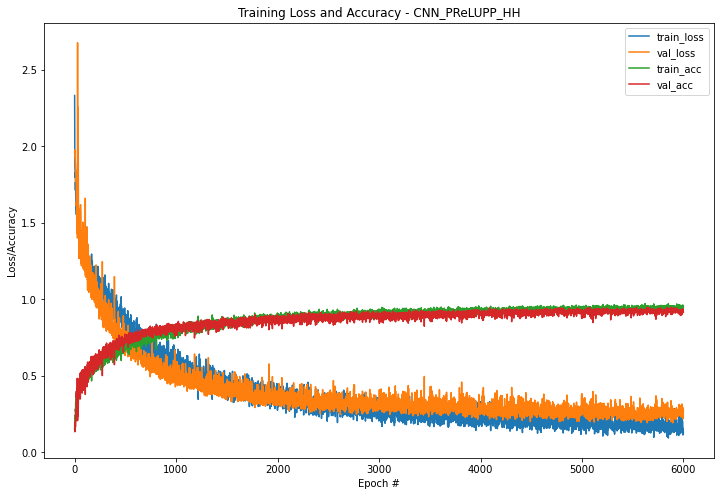

In [ ]:
plot_loss(history,epocas,nn_base_arch+"PP_HH")

### Evaluación con el subconjunto de test

In [ ]:
test_eval = history.model.evaluate(x_test, y_test)

110/110 [==============================] - 0s 4ms/step - loss: 0.2424 - accuracy: 0.9326 - mse: 12.2226
